# **Importing HDB Resale Flat Prices For Each Time Period**

In [ ]:
import pandas as pd
import numpy as np

HDB_resale_flat_1990_to_1999 = pd.read_csv('Data/1990-1999.csv')
HDB_resale_flat_2000_to_Feb_2012 = pd.read_csv('Data/2000-Feb2012.csv')
HDB_resale_flat_Mar_2012_to_2014 = pd.read_csv('Data/Mar2012-2014.csv')
HDB_resale_flat_2015_to_2016 = pd.read_csv('Data/2015-2016.csv')
HDB_resale_flat_2017_onwards = pd.read_csv('Data/2017 Onwards.csv')

# Note: The "remaining lease" column is only provided for the HDB resale flat dataset from 2015 onwards. 
# However, the column can be derived for HDB resale flat transaction records before 2015 since all HDB flats have 99-year lease
HDB_resale_flat_prices_combined = pd.concat([HDB_resale_flat_1990_to_1999, HDB_resale_flat_2000_to_Feb_2012, HDB_resale_flat_Mar_2012_to_2014,
                                             HDB_resale_flat_2015_to_2016, HDB_resale_flat_2017_onwards], axis = 0)

# **Exploratory Data Analysis (EDA)**

In [ ]:
# Structure of data
HDB_resale_flat_prices_combined.info()

In [ ]:
HDB_resale_flat_prices_combined.columns

In [ ]:
HDB_resale_flat_prices_combined.head(10)

In [ ]:
HDB_resale_flat_prices_combined.tail(10)

# **Feature Engineering**

## **Standardizing the remaining lease (a combination of years and months) to the total number of months remaining in the lease**

In [ ]:
remaining_lease_years = HDB_resale_flat_prices_combined.remaining_lease.str.extract(r'(\d+) years (\d+) months')[0]
remaining_lease_months = HDB_resale_flat_prices_combined.remaining_lease.str.extract(r'(\d+) years (\d+) months')[1]
HDB_resale_flat_prices_combined["remaining_lease_months"] = (remaining_lease_years.astype(float) * 12) + remaining_lease_months.astype(float)

## **Imputing missing records into the 'remaining_lease_months' column**

In [ ]:
HDB_resale_flat_prices_combined.remaining_lease_months.fillna(
    (99 - (pd.DatetimeIndex(HDB_resale_flat_prices_combined.month).year - HDB_resale_flat_prices_combined.lease_commence_date.astype(int))) * 12, inplace = True)
# Converting all records in the "remaining_lease_months" to int
HDB_resale_flat_prices_combined.remaining_lease_months = HDB_resale_flat_prices_combined.remaining_lease_months.astype(int)
HDB_resale_flat_prices_combined.reset_index(drop = True, inplace = True)
HDB_resale_flat_prices_combined

In [ ]:
from helper_functions import reverse_lookup

# Obtained from https://www.hdb.gov.sg/about-us/history/hdb-towns-your-home 
region_dict = {'CENTRAL': ['BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'TOA PAYOH'],
               'NORTH': ['SEMBAWANG', 'WOODLANDS', 'YISHUN'],
               'NORTHEAST': ['ANG MO KIO', 'HOUGANG', 'PUNGGOL', 'SENGKANG', 'SERANGOON'],
               'EAST': ['BEDOK', 'PASIR RIS', 'TAMPINES'],
               'WEST': ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST', 'LIM CHU KANG']}

HDB_resale_flat_prices_combined = reverse_lookup(HDB_resale_flat_prices_combined, 'town', region_dict, 'region')
HDB_resale_flat_prices_combined

## **Encoding Storey Ranges With Median Storey Numbers**

In [ ]:
median_storey_dict = {'2': '01 TO 03', '3': '01 TO 05', '5': '04 TO 06', '8': ['07 TO 09', '06 TO 10'], '11': '10 TO 12', '13': '11 TO 15', 
                      '14': '13 TO 15', '17': '16 TO 18', '18': '16 TO 20', '20': '19 TO 21', '23': ['22 TO 24', '21 TO 25'], '26': '25 TO 27', 
                      '28': '26 TO 30', '29': '28 TO 30', '32': '31 TO 33', '33': '31 TO 35', '35': '34 TO 36', '38': ['37 TO 39',  '36 TO 40'], 
                      '41': '40 TO 42', '44': '43 TO 45', '47': '46 TO 48', '50': '49 TO 51'}
HDB_resale_flat_prices_combined = reverse_lookup(HDB_resale_flat_prices_combined, 'storey_range', median_storey_dict, 'median_storey')
HDB_resale_flat_prices_combined['median_storey'] = HDB_resale_flat_prices_combined['median_storey'].astype(int)

## **Standardizing The Naming Conventions of All Flat Models & Flat Types**

In [ ]:
print(HDB_resale_flat_prices_combined.flat_model.unique(), len(HDB_resale_flat_prices_combined.flat_model.unique()))
HDB_resale_flat_prices_combined['flat_model_standardized'] = HDB_resale_flat_prices_combined.flat_model.str.upper()
print(HDB_resale_flat_prices_combined.flat_model_standardized.unique(), len(HDB_resale_flat_prices_combined.flat_model_standardized.unique()))

In [ ]:
print(HDB_resale_flat_prices_combined.flat_type.unique())
HDB_resale_flat_prices_combined['flat_type_standardized'] = HDB_resale_flat_prices_combined.flat_type.str.replace(
    pat = r'(\w{5}) (\w{10})', repl = r'\1-\2', regex = True).str.strip('\-')
print(HDB_resale_flat_prices_combined.flat_type_standardized.unique())
HDB_resale_flat_prices_combined

## **Converting The Floor Area From Square Metres To Square Feet**

In [ ]:
import area_unit_conversion

HDB_resale_flat_prices_combined['resale_price_per_sqm'] = (HDB_resale_flat_prices_combined.resale_price/HDB_resale_flat_prices_combined.floor_area_sqm)
HDB_resale_flat_prices_combined['floor_area_sqft'] = area_unit_conversion.convert('m2', 'ft2', HDB_resale_flat_prices_combined.floor_area_sqm)
HDB_resale_flat_prices_combined['resale_price_per_sqft'] = HDB_resale_flat_prices_combined.resale_price/HDB_resale_flat_prices_combined.floor_area_sqft

## **Obtaining The Full Address By Combining The Block Number & Street Name Together**

In [ ]:
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined.block + ' ' + HDB_resale_flat_prices_combined.street_name.astype(str)

In [ ]:
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" LOR ", " LORONG ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" NTH\s?", " NORTH ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" UPP ", " UPPER ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" KG ",  " KAMPONG ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" TG ", " TANJONG ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" BT ", " BUKIT ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" C'WEALTH ", " COMMONWEALTH ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" NILE RD", " NILE RD, BUKIT MERAH", regex = True)

## The Following Addresses Were Geocoded Using Google Maps Platform Geocoding API Since Nominatim Geocoding API Is Unable to Handle This Addresses

In [ ]:
problematic_addresses = ['1 JLN PASAR BARU', '5 BUANGKOK STH FARMWAY 1', '24 JLN MEMBINA BARAT', '51 NILE RD, BUKIT MERAH', '54 NILE RD, BUKIT MERAH',
                         '7 KIM TIAN PL', '8 KIM TIAN PL', '120 KIM TIAN PL', '120A KIM TIAN PL', '121 KIM TIAN PL', '121A KIM TIAN PL',
                         '18 KAMPONG BAHRU HILL', '19 KAMPONG BAHRU HILL', '22 KAMPONG BAHRU HILL', '23 KAMPONG BAHRU HILL', '24 KAMPONG BAHRU HILL',
                         '5 YUNG PING RD', '6 YUNG PING RD', '159 YUNG PING RD', '160 YUNG PING RD', '161 YUNG PING RD', '162 YUNG PING RD', '163 YUNG PING RD', 
                         '687A WOODLANDS DR 75', '688B WOODLANDS DR 75', '688C WOODLANDS DR 75', '688D WOODLANDS DR 75', '688E WOODLANDS DR 75', '688F WOODLANDS DR 75',
                         '689A WOODLANDS DR 75', '689B WOODLANDS DR 75', '689C WOODLANDS DR 75', '689D WOODLANDS DR 75', '689E WOODLANDS DR 75', '689F WOODLANDS DR 75',
                         '690A WOODLANDS DR 75', '690B WOODLANDS DR 75', '690C WOODLANDS DR 75', '888A TAMPINES ST 81']

for BOON_LAY_DR in HDB_resale_flat_prices_combined['address'][HDB_resale_flat_prices_combined['address'].str.contains('BOON LAY DR')].unique():
    problematic_addresses.append(BOON_LAY_DR)

In [ ]:
problematic_indices = []
for address in problematic_addresses:
    problematic_indices.append(np.where(HDB_resale_flat_prices_combined['address'].unique() == address))
unique_addresses_cleaned = np.delete(HDB_resale_flat_prices_combined['address'].unique(), problematic_indices)

In [ ]:
import time
from helper_functions import geocoding_GoogleMaps, geocoding_Nominatim

start_geocoding = time.perf_counter()
HDB_block_lat_dict, HDB_block_lon_dict = {}, {}
for address in problematic_addresses:
    HDB_block_lat_dict[address], HDB_block_lon_dict[address] = geocoding_GoogleMaps(address)

for unique_address in unique_addresses_cleaned:
    HDB_block_lat_dict[unique_address], HDB_block_lon_dict[unique_address] = geocoding_Nominatim(unique_address)
print('Duration: {}s'.format(time.perf_counter() - start_geocoding)) 

In [ ]:
HDB_resale_flat_prices_combined['latitude'] = HDB_resale_flat_prices_combined['address'].map(HDB_block_lat_dict)
HDB_resale_flat_prices_combined['longitude'] = HDB_resale_flat_prices_combined['address'].map(HDB_block_lon_dict)

In [ ]:
HDB_resale_flat_prices_combined.to_csv('Data/HDB Resale Flat Prices/Combined & Processed.csv', index = None)

In [2]:
import pandas as pd
import numpy as np

HDB_resale_flat_prices_combined = pd.read_csv('Data/Combined & Processed.csv', index_col = None, low_memory = False)
HDB_resale_flat_prices_combined.head(10)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,region,median_storey,flat_model_standardized,flat_type_standardized,resale_price_per_sqm,floor_area_sqft,resale_price_per_sqft,address,latitude,longitude
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,...,NORTHEAST,11,IMPROVED,1 ROOM,290.322581,333.679691,26.971974,309 ANG MO KIO AVE 1,1.364390,103.843330
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,...,NORTHEAST,5,IMPROVED,1 ROOM,193.548387,333.679691,17.981316,309 ANG MO KIO AVE 1,1.364390,103.843330
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,...,NORTHEAST,11,IMPROVED,1 ROOM,258.064516,333.679691,23.975088,309 ANG MO KIO AVE 1,1.364390,103.843330
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,...,NORTHEAST,8,IMPROVED,1 ROOM,193.548387,333.679691,17.981316,309 ANG MO KIO AVE 1,1.364390,103.843330
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,...,NORTHEAST,5,NEW GENERATION,3 ROOM,646.575343,785.761853,60.069091,216 ANG MO KIO AVE 1,1.366209,103.841476
5,1990-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,46000.0,...,NORTHEAST,2,NEW GENERATION,3 ROOM,686.567164,721.178687,63.784470,211 ANG MO KIO AVE 3,1.369205,103.841719
6,1990-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,07 TO 09,67.0,NEW GENERATION,1977,42000.0,...,NORTHEAST,8,NEW GENERATION,3 ROOM,626.865672,721.178687,58.237994,202 ANG MO KIO AVE 3,1.368461,103.844515
7,1990-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,10 TO 12,67.0,NEW GENERATION,1977,38000.0,...,NORTHEAST,11,NEW GENERATION,3 ROOM,567.164179,721.178687,52.691518,235 ANG MO KIO AVE 3,1.368739,103.848851
8,1990-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,04 TO 06,67.0,NEW GENERATION,1977,40000.0,...,NORTHEAST,5,NEW GENERATION,3 ROOM,597.014925,721.178687,55.464756,235 ANG MO KIO AVE 3,1.368739,103.848851
9,1990-01,ANG MO KIO,3 ROOM,232,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,47000.0,...,NORTHEAST,2,NEW GENERATION,3 ROOM,701.492537,721.178687,65.171088,232 ANG MO KIO AVE 3,1.368527,103.837027


## **Summary Statistics Of Dataset Including Derived Variables**

In [3]:
HDB_resale_flat_prices_combined.info()
HDB_resale_flat_prices_combined.loc[:, HDB_resale_flat_prices_combined.columns != 'lease_commence_date'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892418 entries, 0 to 892417
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   month                    892418 non-null  object 
 1   town                     892418 non-null  object 
 2   flat_type                892418 non-null  object 
 3   block                    892418 non-null  object 
 4   street_name              892418 non-null  object 
 5   storey_range             892418 non-null  object 
 6   floor_area_sqm           892418 non-null  float64
 7   flat_model               892418 non-null  object 
 8   lease_commence_date      892418 non-null  int64  
 9   resale_price             892418 non-null  float64
 10  remaining_lease          183368 non-null  object 
 11  remaining_lease_months   892418 non-null  int64  
 12  region                   892418 non-null  object 
 13  median_storey            892418 non-null  int64  
 14  flat

,floor_area_sqm,resale_price,remaining_lease_months,median_storey,resale_price_per_sqm,floor_area_sqft,resale_price_per_sqft,latitude,longitude
count,892418.000000,8.924180e+05,892418.000000,892418.000000,892418.000000,892418.000000,892418.000000,892418.000000,892418.000000
mean,95.709227,3.106401e+05,976.718090,7.646910,3206.550200,1030.200818,297.899629,1.361529,103.839445
std,25.904950,1.619536e+05,124.891342,4.768582,1426.189761,278.837280,132.497973,0.041681,0.073722
min,28.000000,5.000000e+03,516.000000,2.000000,161.290323,301.388108,14.984430,1.270369,103.685206
25%,73.000000,1.900000e+05,900.000000,5.000000,2269.230769,785.761853,210.819405,1.333670,103.773297
50%,93.000000,2.890000e+05,996.000000,8.000000,2890.109890,1001.039073,268.501227,1.354788,103.843656
75%,113.000000,4.050000e+05,1080.000000,11.000000,4042.553191,1216.316293,375.567205,1.382078,103.897814
max,307.000000,1.418000e+06,1212.000000,50.000000,14731.182800,3304.505327,1368.577948,1.457845,103.987631


# **Visualisations**

## **Histogram Plots - To Understand The Statistical Distribution of Each Variable**

### **Predictor Variables**

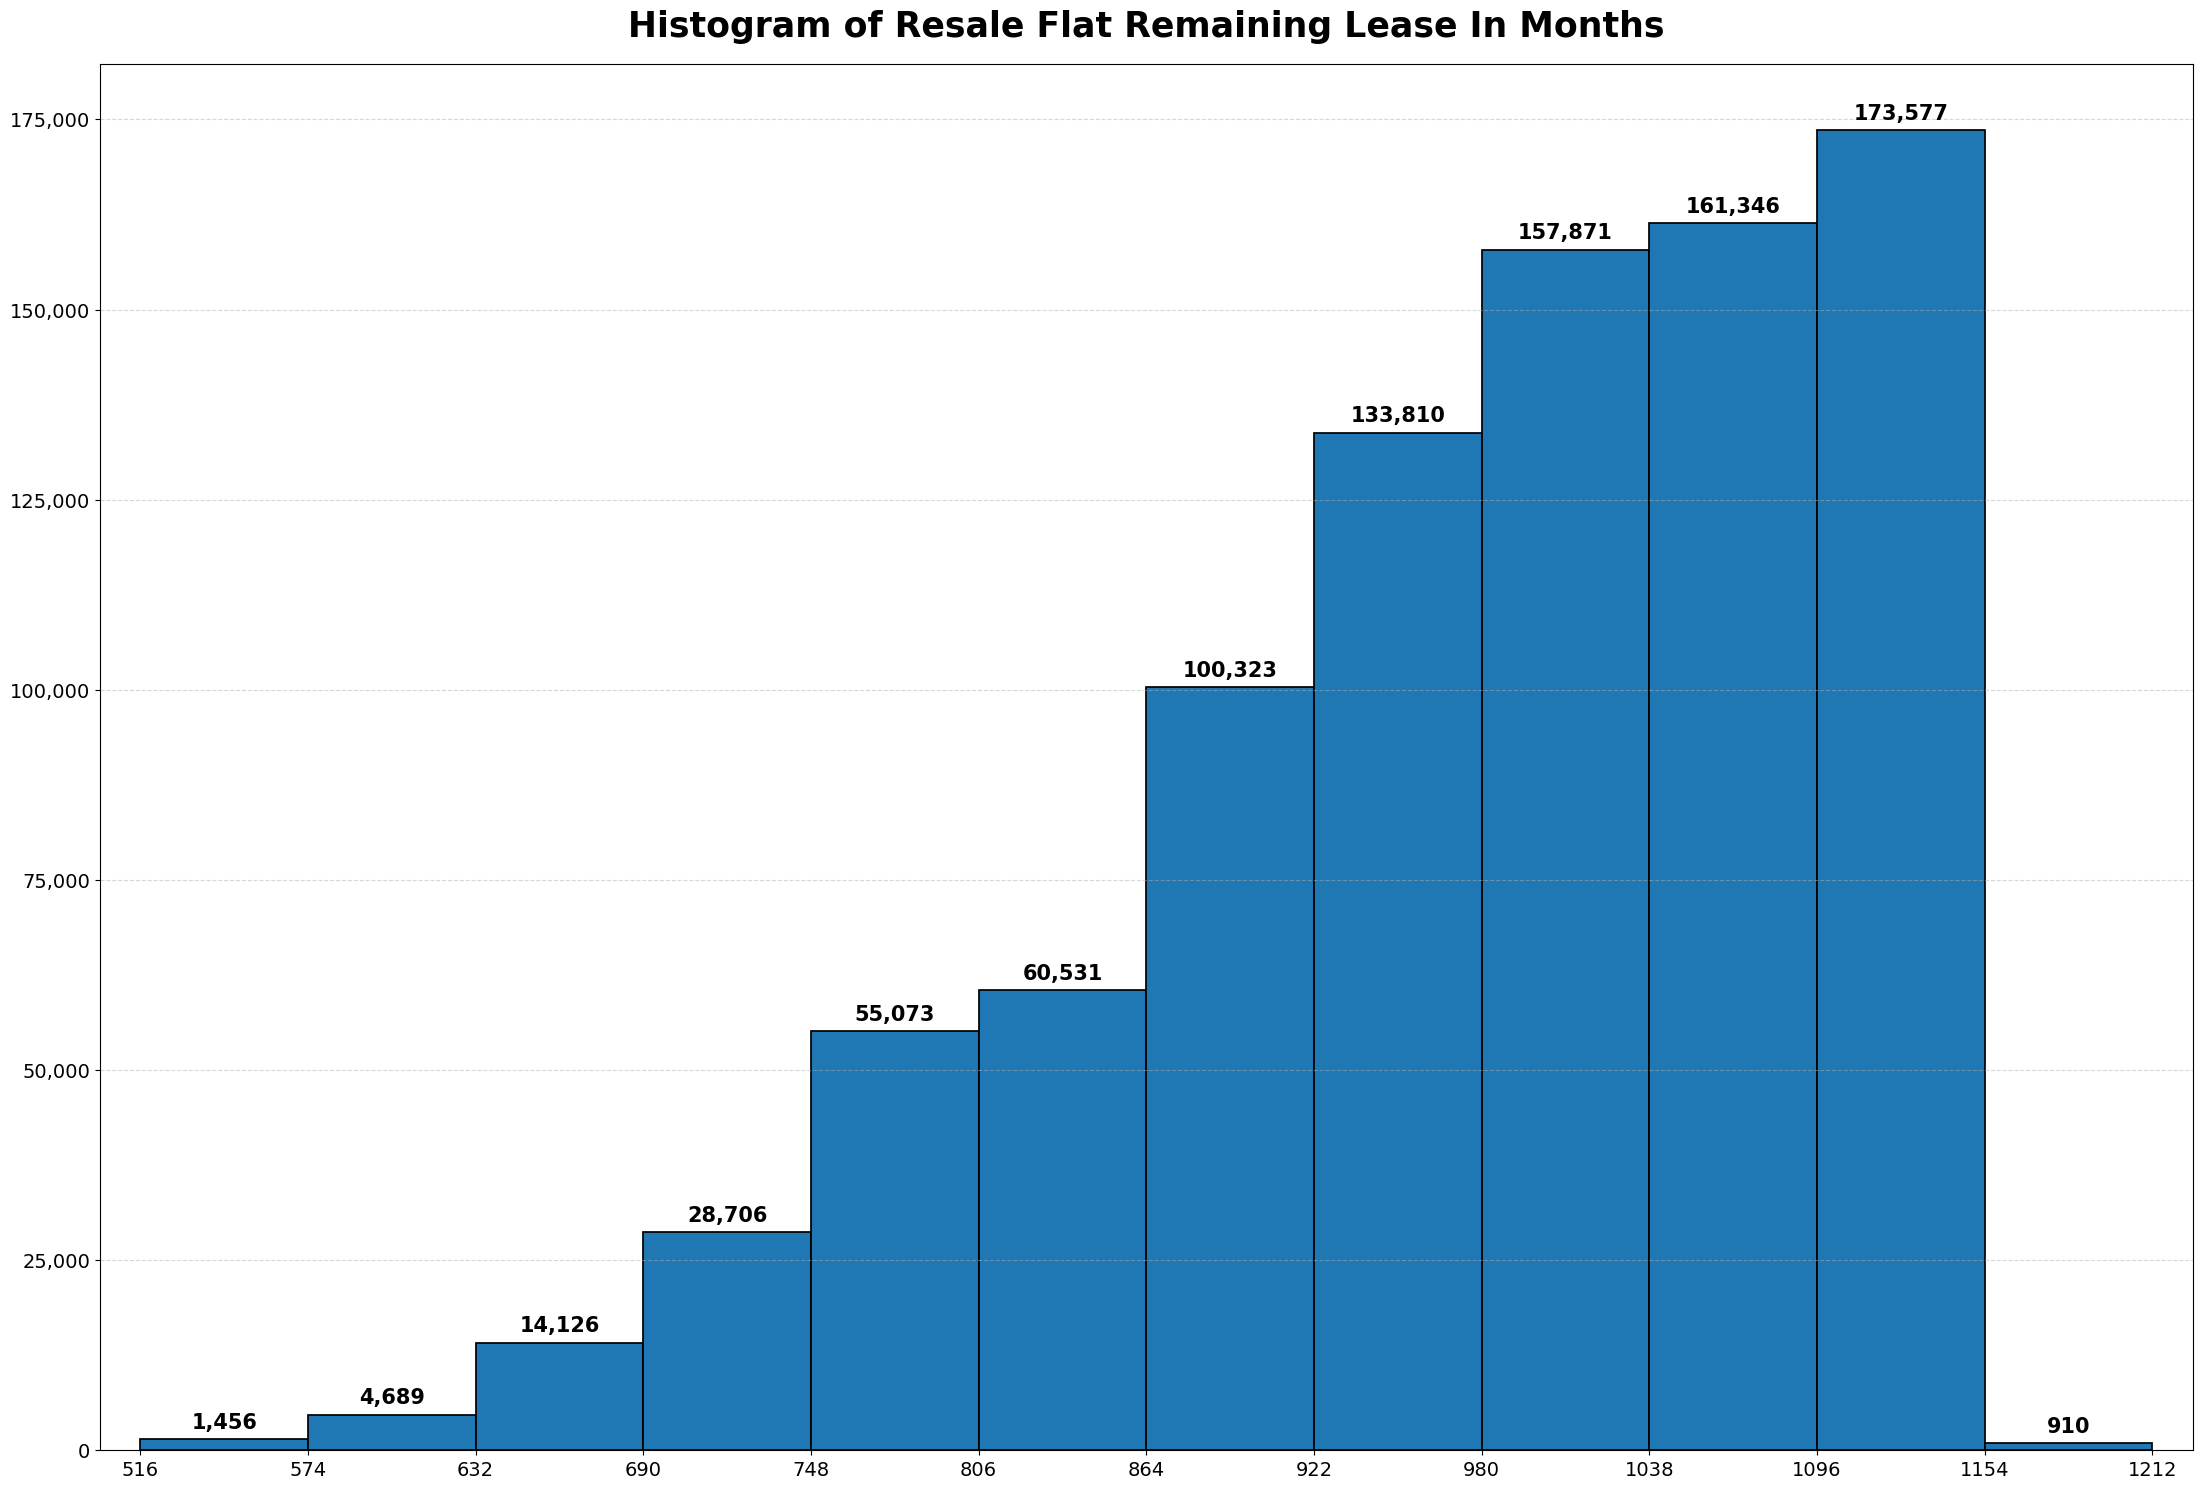

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
import seaborn as sns

plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.remaining_lease_months), bins = 12, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title(r'Histogram of Resale Flat Remaining Lease In Months', size = 25, weight = 'bold', pad = 20)
plt.xticks(bins)
# plt.yticks(np.linspace(0, 180000, 19))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 15, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
# plt.savefig('Plots/Histograms/Remaining Leases (Months) of Resale Flats.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

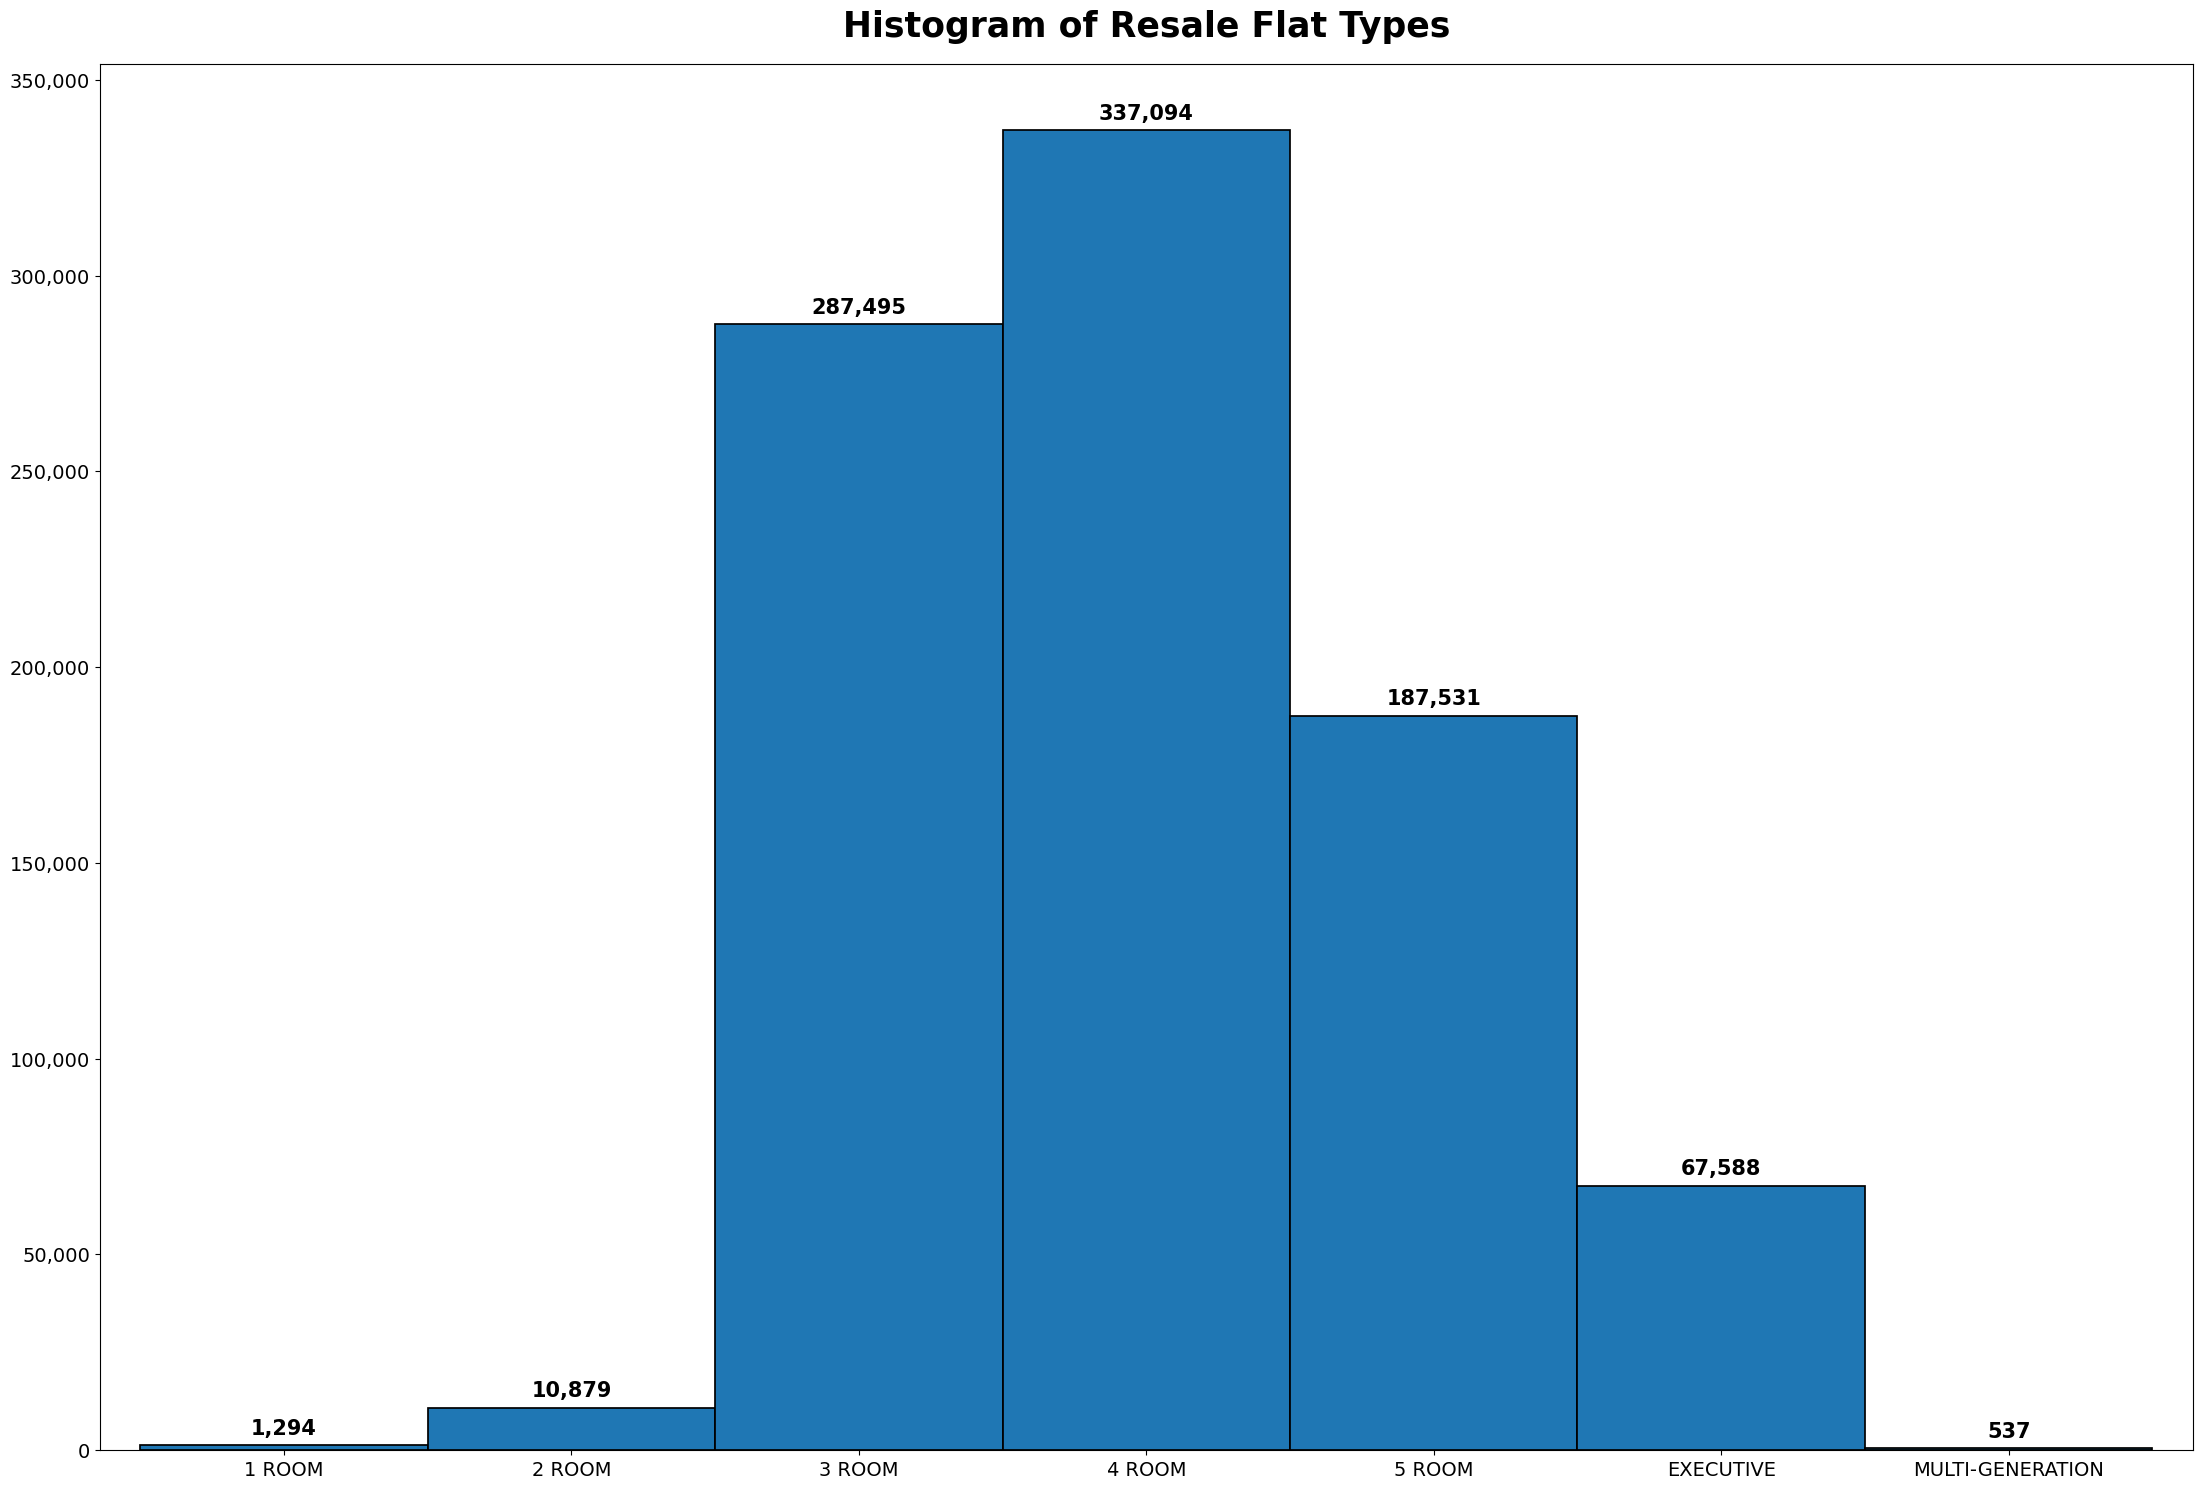

In [5]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.flat_type_standardized), bins = 7, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flat Types', size = 25, weight = 'bold', pad = 20)
plt.xticks([(container._x0 + (container._x0 + container._width))/2 for container in containers], sorted(HDB_resale_flat_prices_combined.flat_type_standardized.unique()))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 15, weight = 'bold')
plt.savefig('Plots/Histograms/Resale Flat Types.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

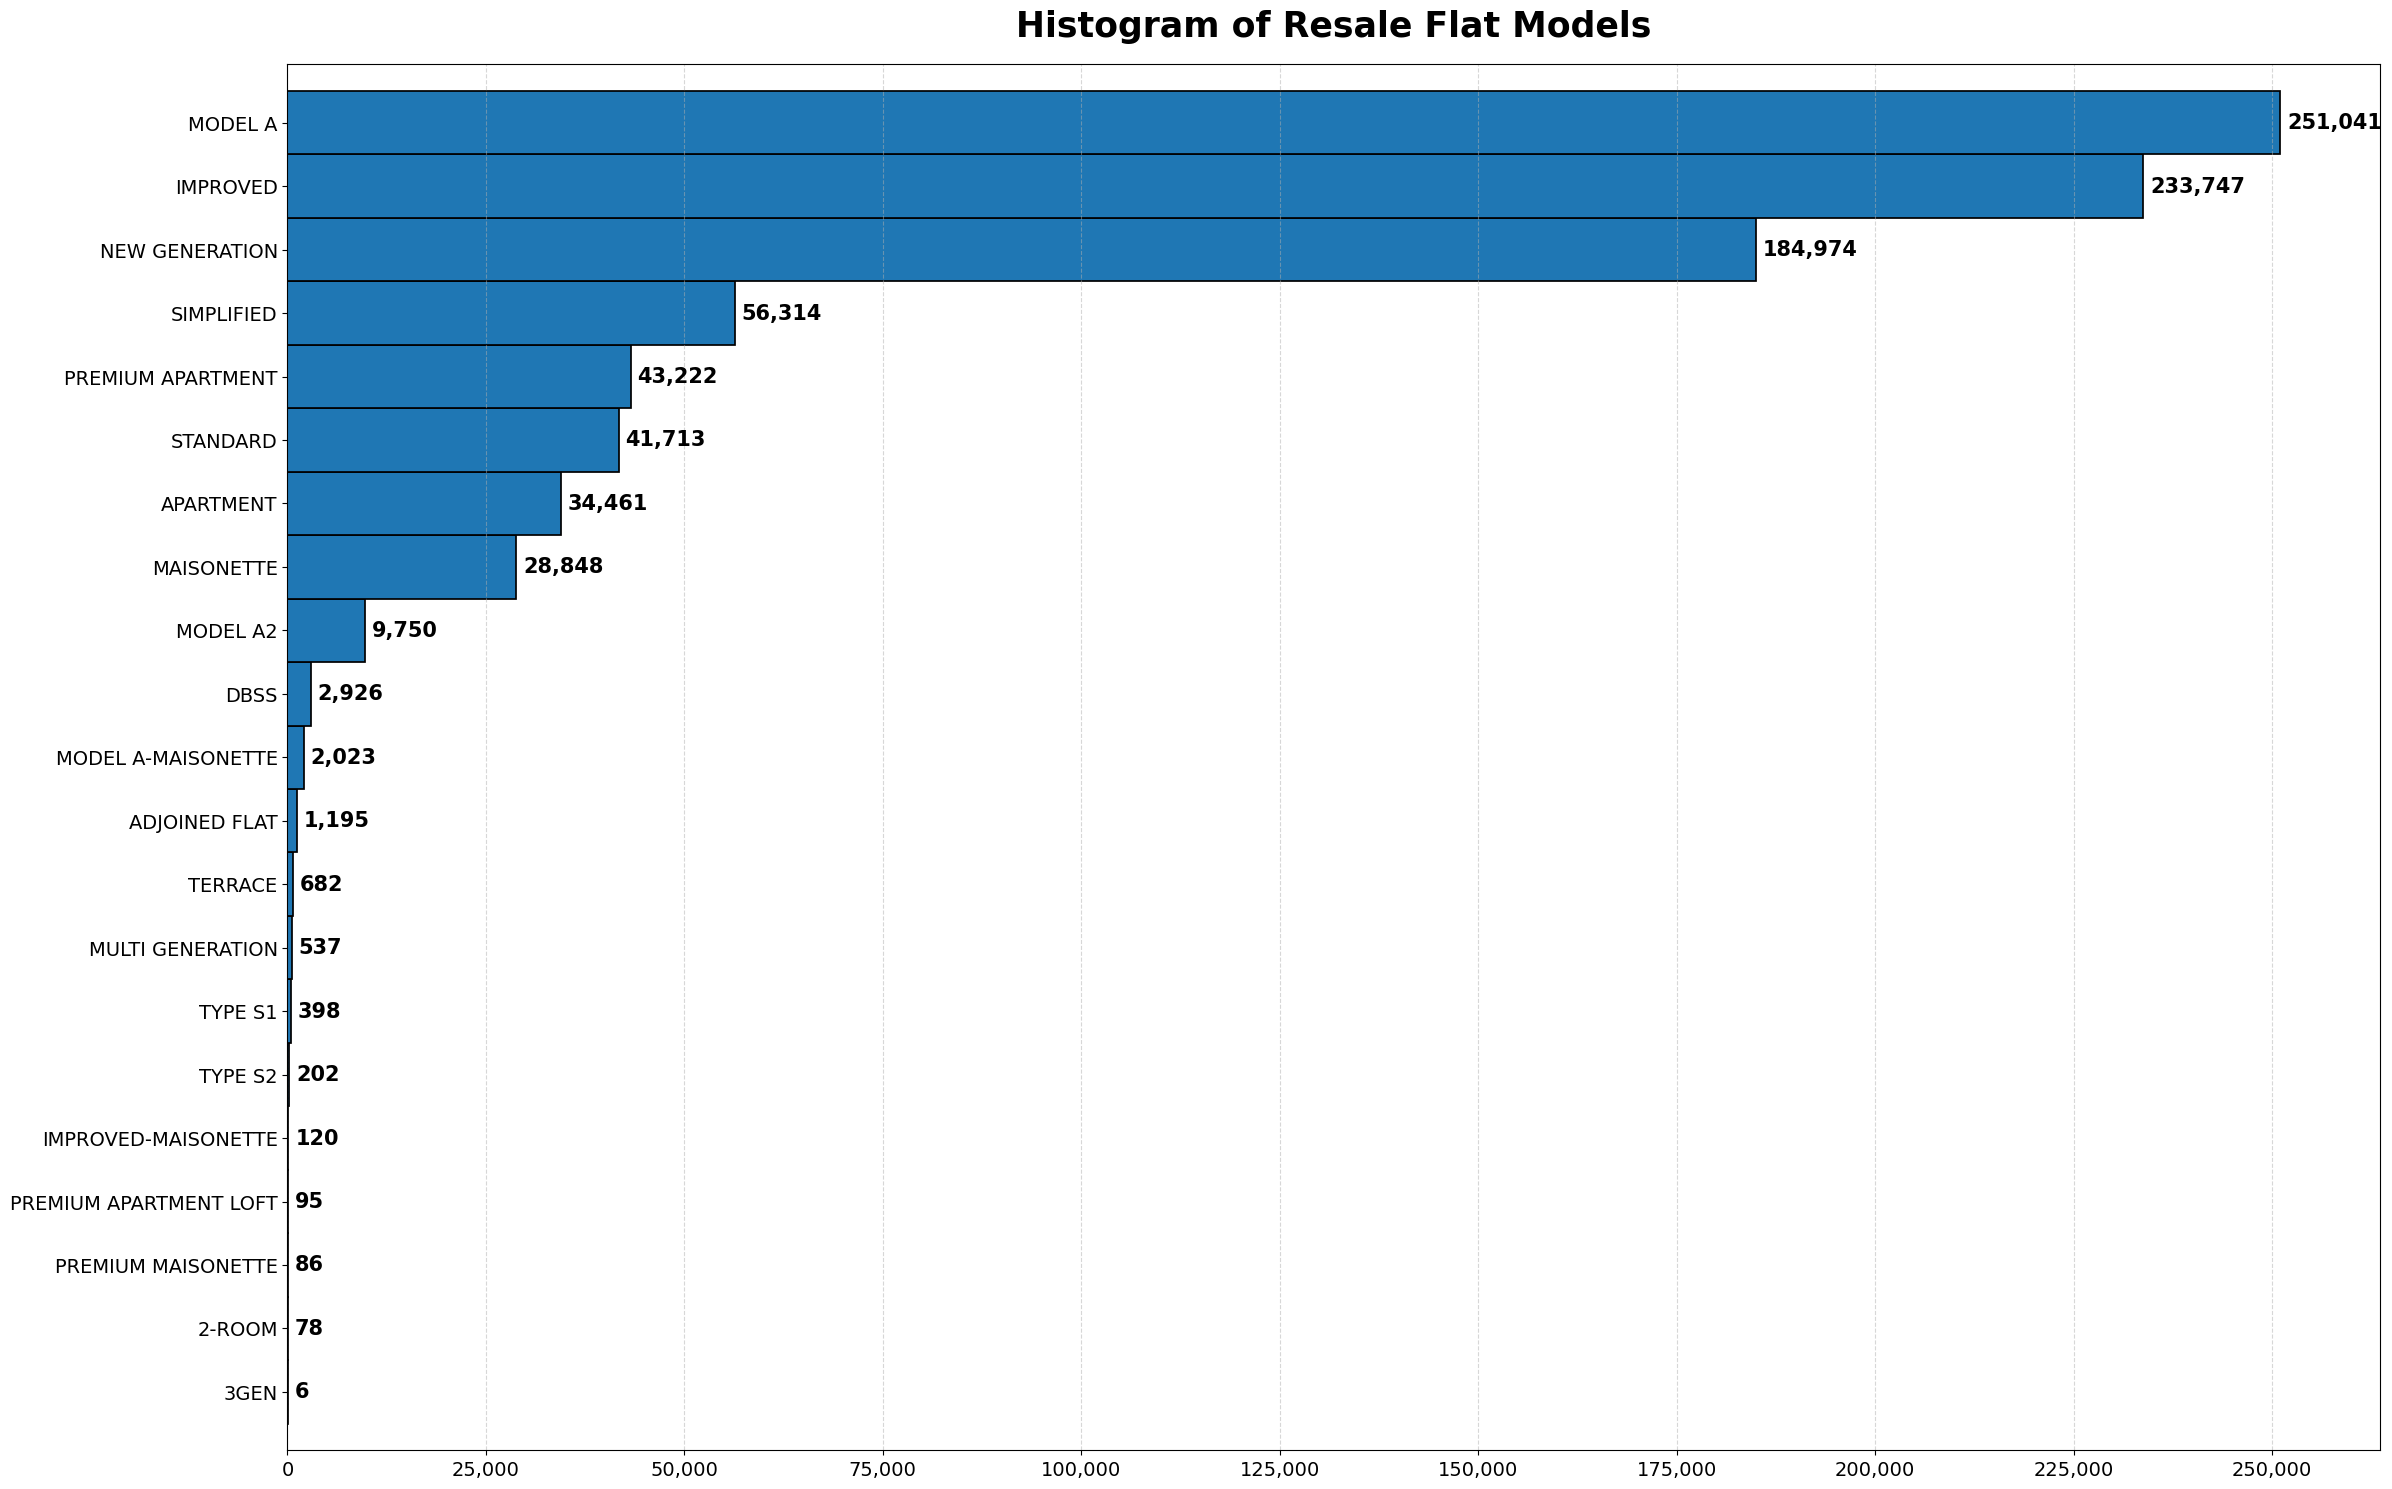

In [6]:
plt.figure(figsize = (27, 18))
plt.margins(y = 0.02, tight = True)
counts_flat_models_sorted = HDB_resale_flat_prices_combined.flat_model_standardized.value_counts(ascending = True)
horizontal_bars = plt.barh(counts_flat_models_sorted.index, counts_flat_models_sorted.values, height = 1.0, edgecolor = 'black', linewidth = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flat Models', size = 25, weight = 'bold', pad = 20)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(np.linspace(0, 250000, 11))
plt.bar_label(horizontal_bars, labels = [f'{counts:,.0f}' for counts in counts_flat_models_sorted.values], padding = 5, size = 15, weight = 'bold')
plt.grid(which = 'both', axis = 'x', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Resale Flat Models.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

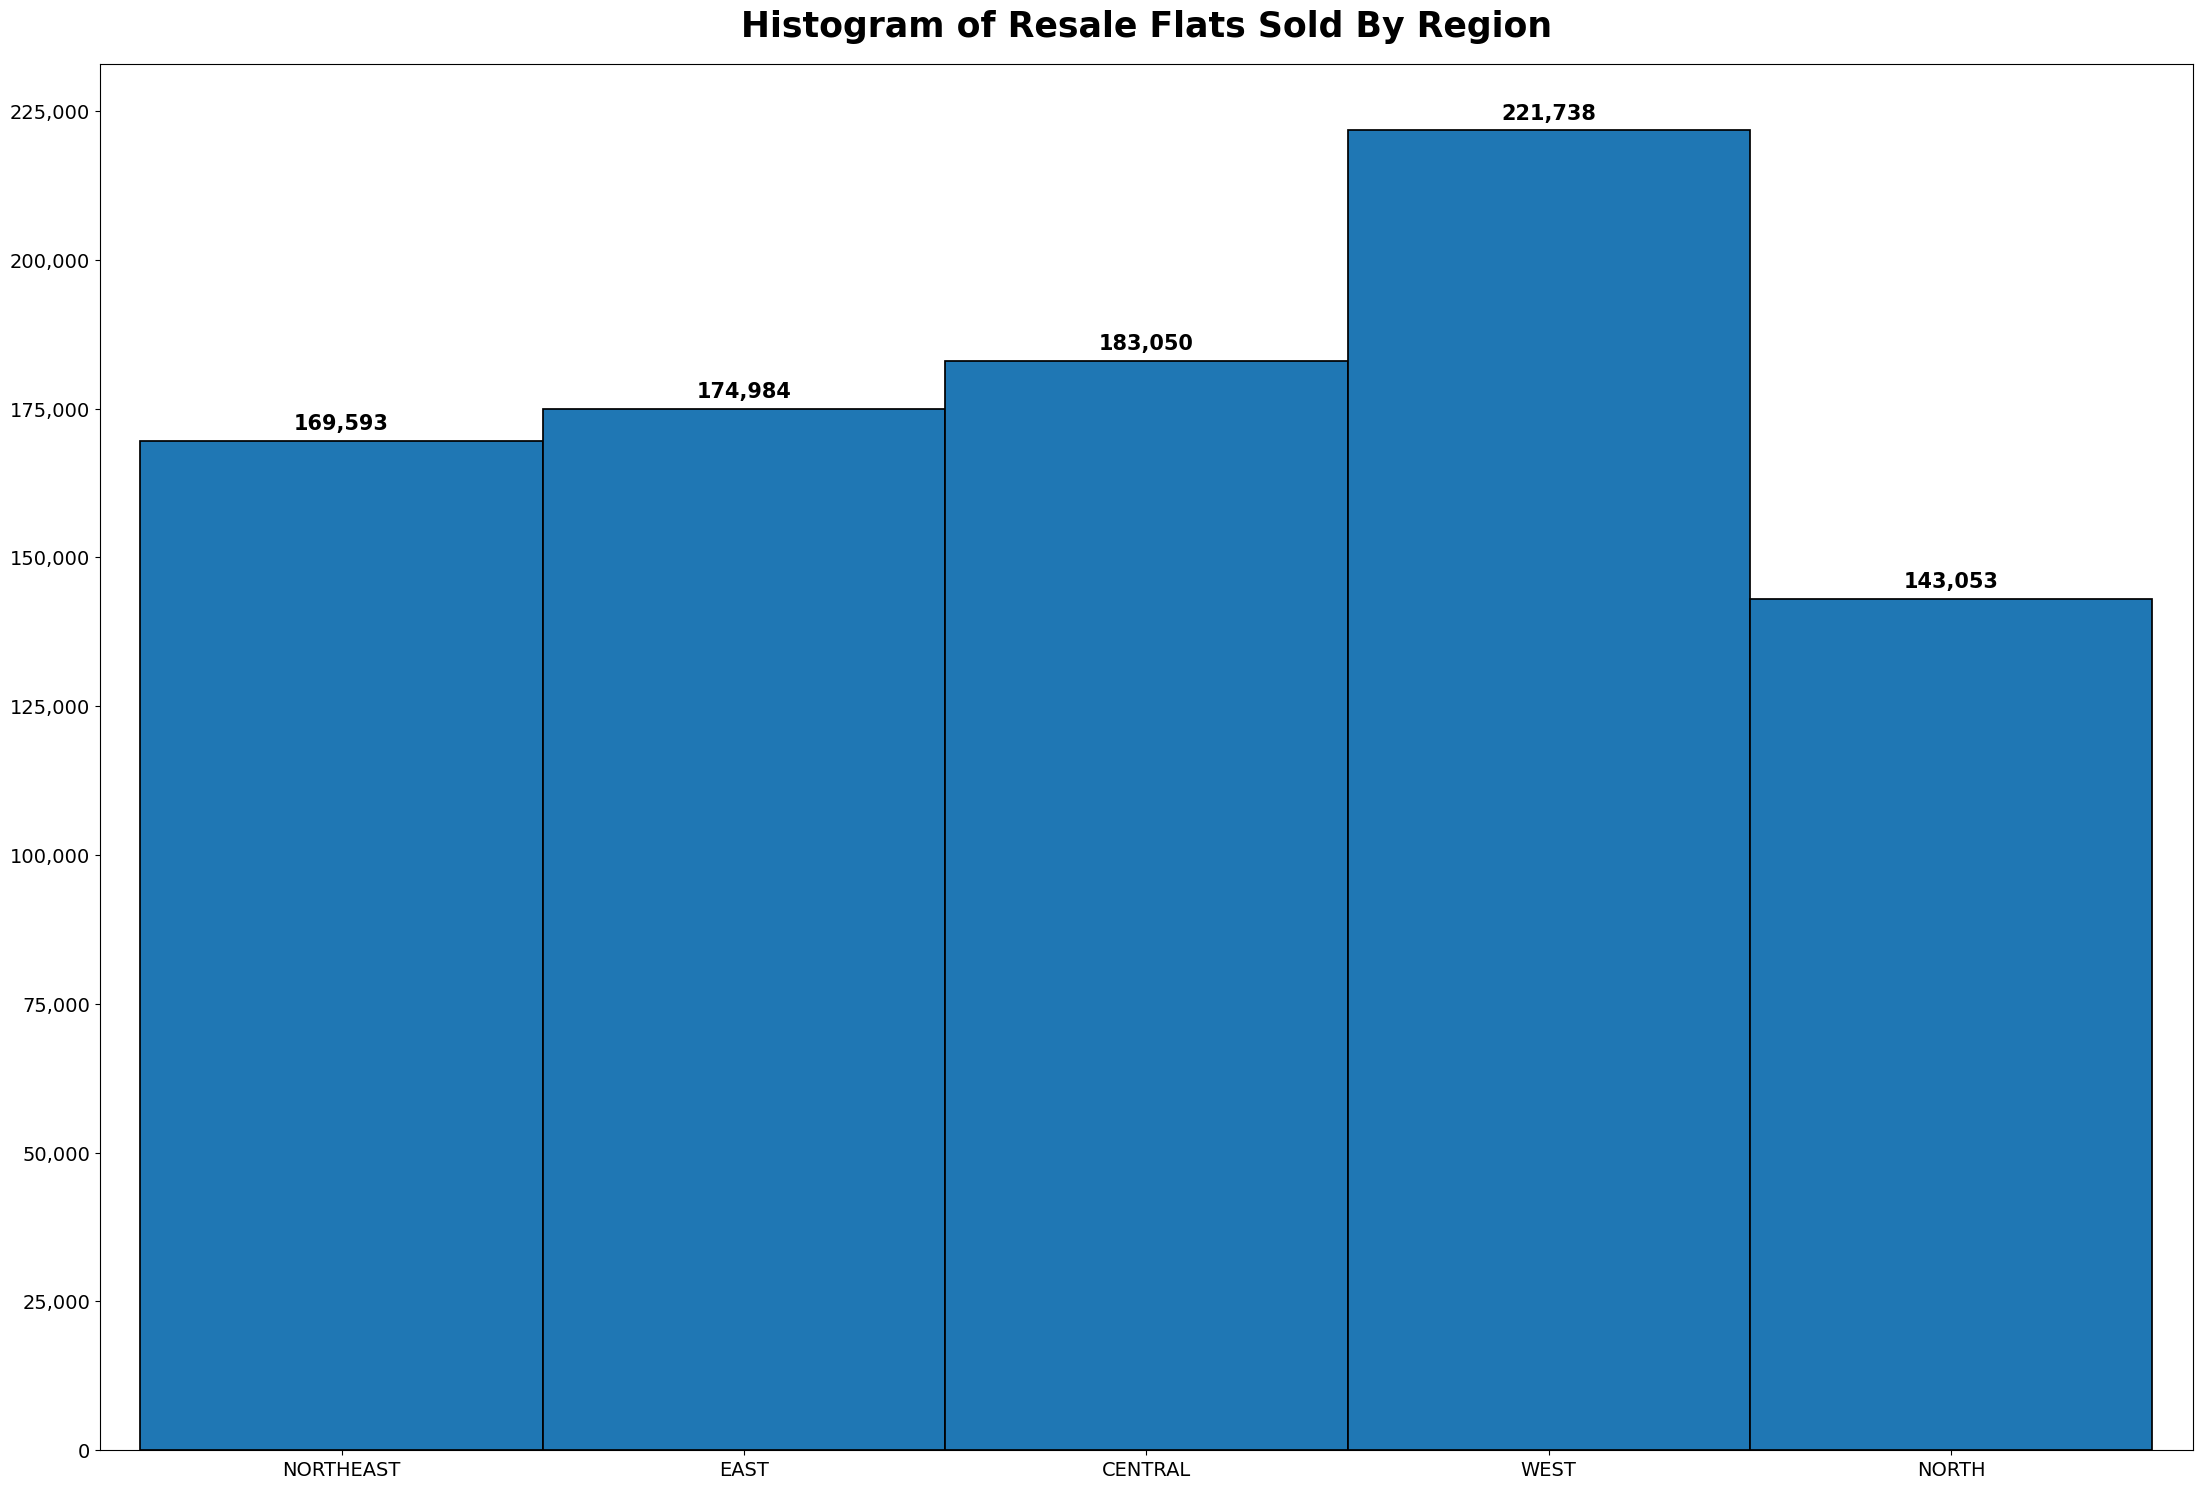

In [7]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(HDB_resale_flat_prices_combined.region, bins = 5, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flats Sold By Region', size = 25, weight = 'bold', pad = 20)
plt.xticks([(container._x0 + (container._x0 + container._width))/2 for container in containers], HDB_resale_flat_prices_combined.region.unique())
plt.yticks(np.linspace(0, 225000, 10))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 15, weight = 'bold')
plt.savefig('Plots/Histograms/Number of Resale Flats Sold By Region.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

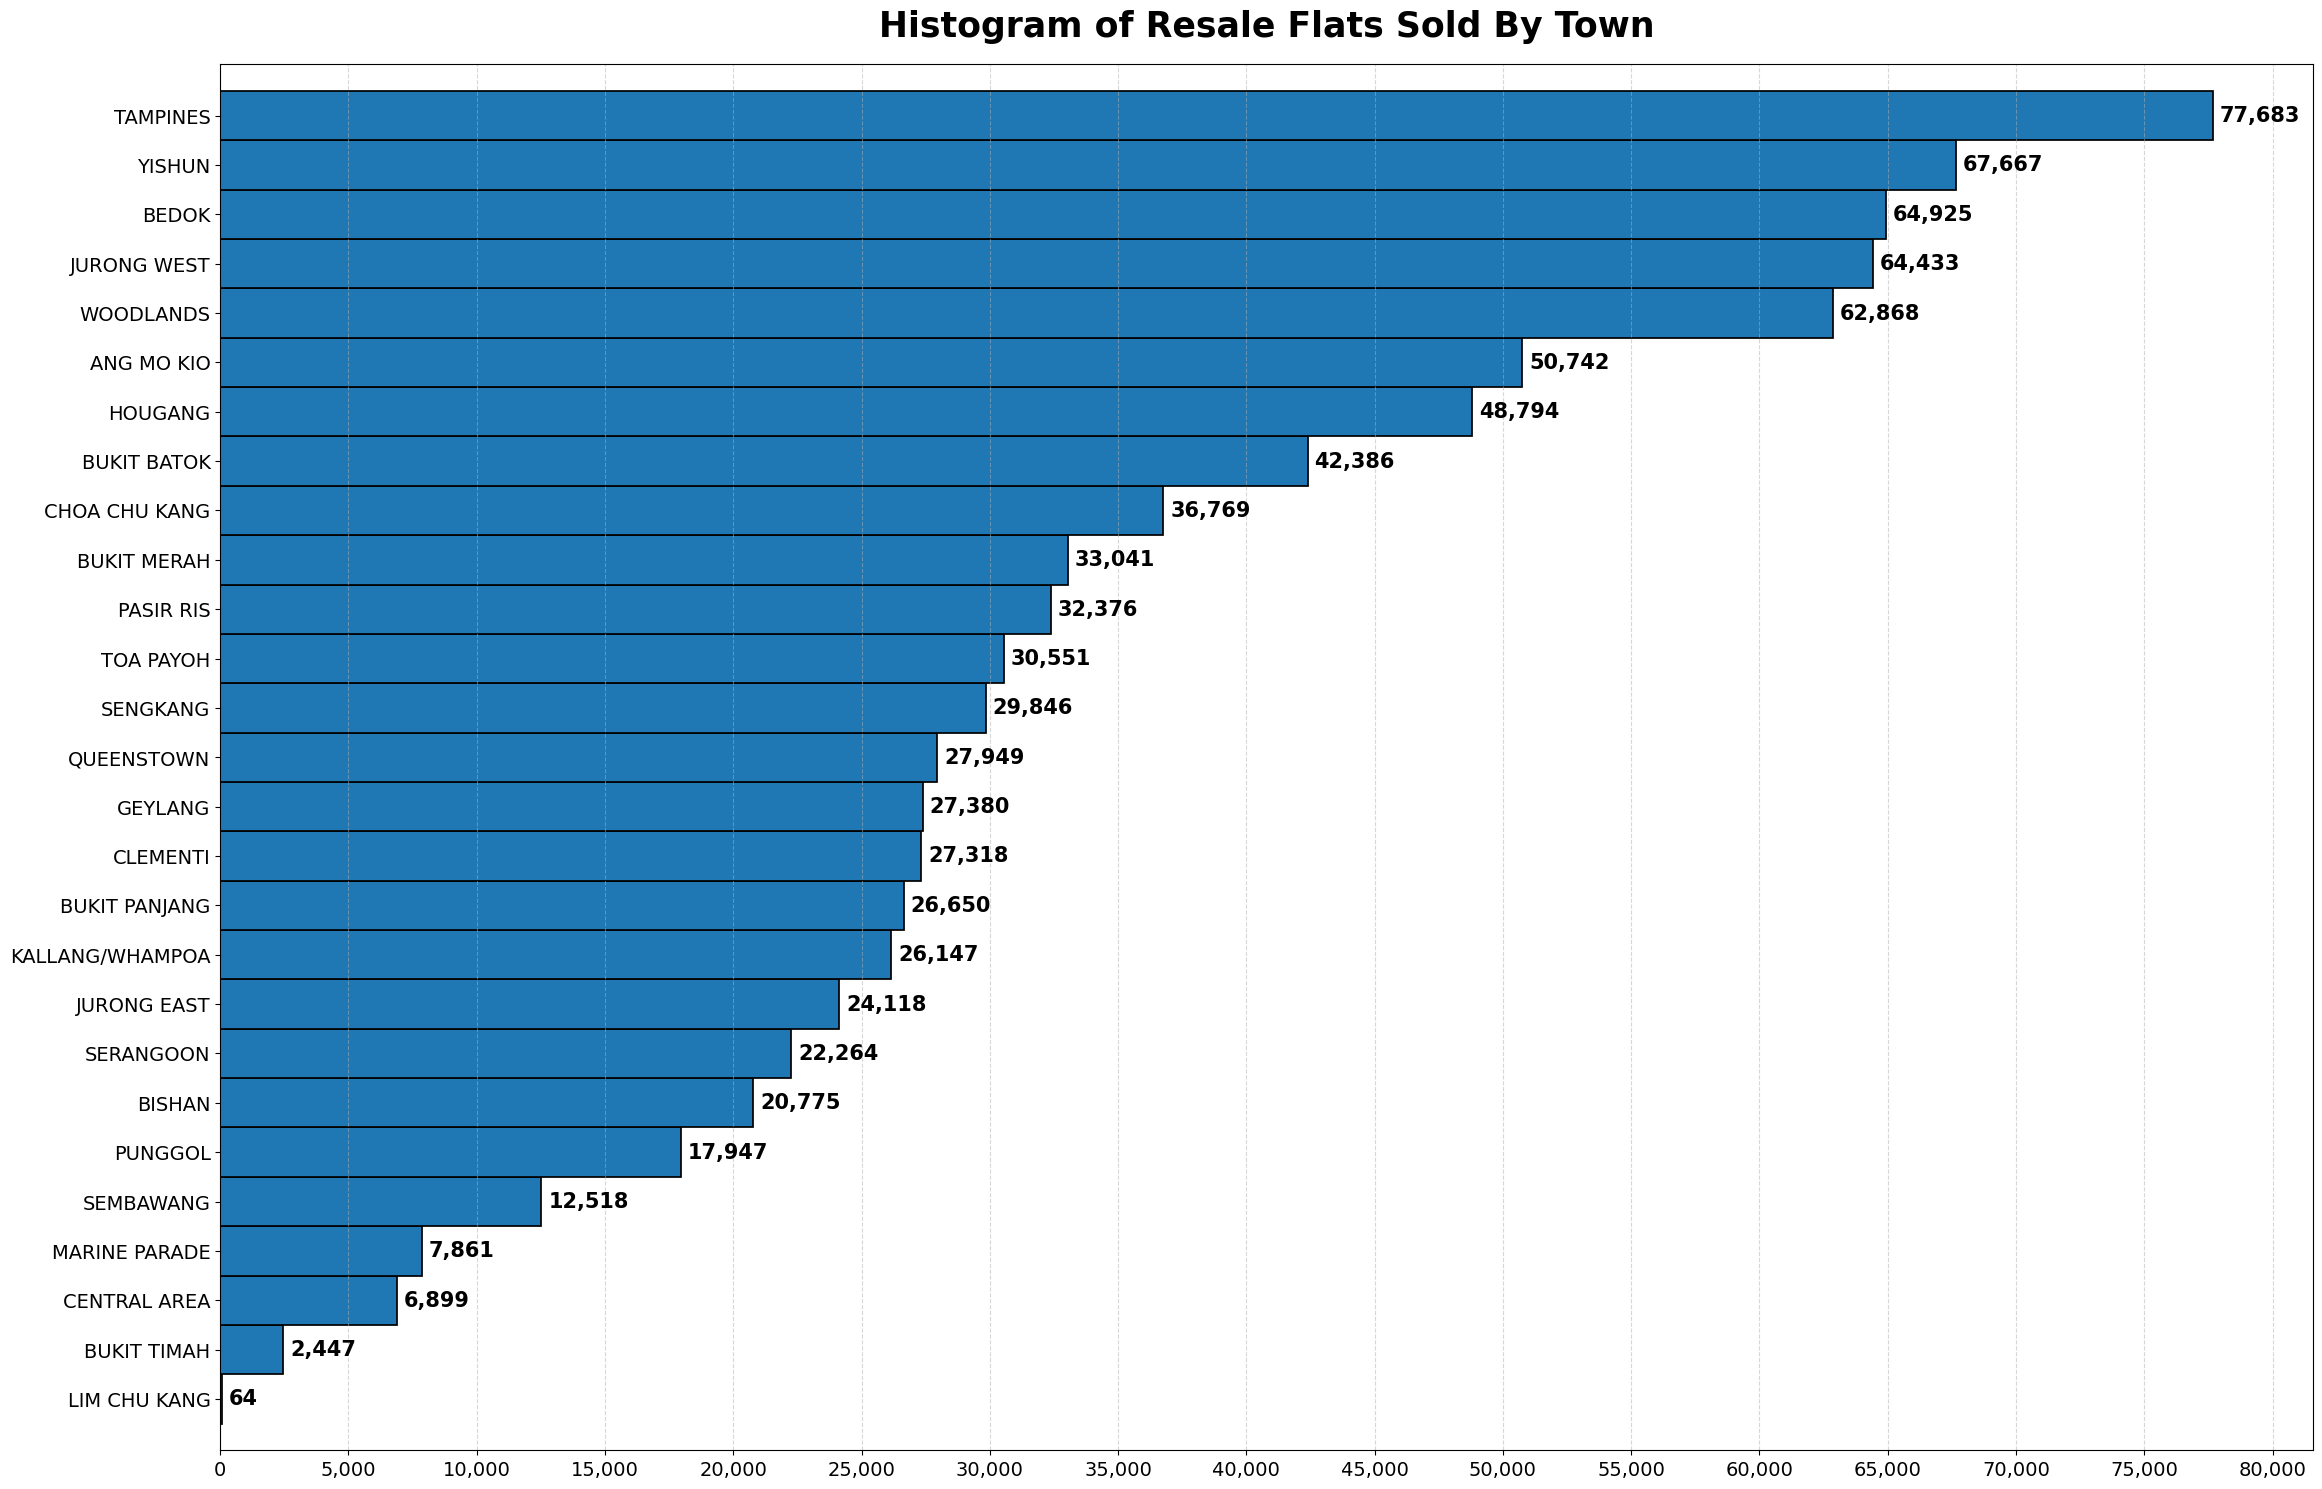

In [8]:
plt.figure(figsize = (27, 18))
plt.margins(y = 0.02, tight = True)
resale_flat_sold_town_sorted = HDB_resale_flat_prices_combined.town.value_counts(ascending = True)
horizontal_bars = plt.barh(resale_flat_sold_town_sorted.index, resale_flat_sold_town_sorted.values, height = 1.0, edgecolor = 'black', 
                           linewidth = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flats Sold By Town', size = 25, weight = 'bold', pad = 20)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(np.linspace(0, 80000, 17))
plt.bar_label(horizontal_bars, labels = [f'{counts:,.0f}' for counts in resale_flat_sold_town_sorted.values], padding = 5, size = 15, weight = 'bold')
plt.grid(which = 'both', axis = 'x', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Number of Resale Flats Sold by Town.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

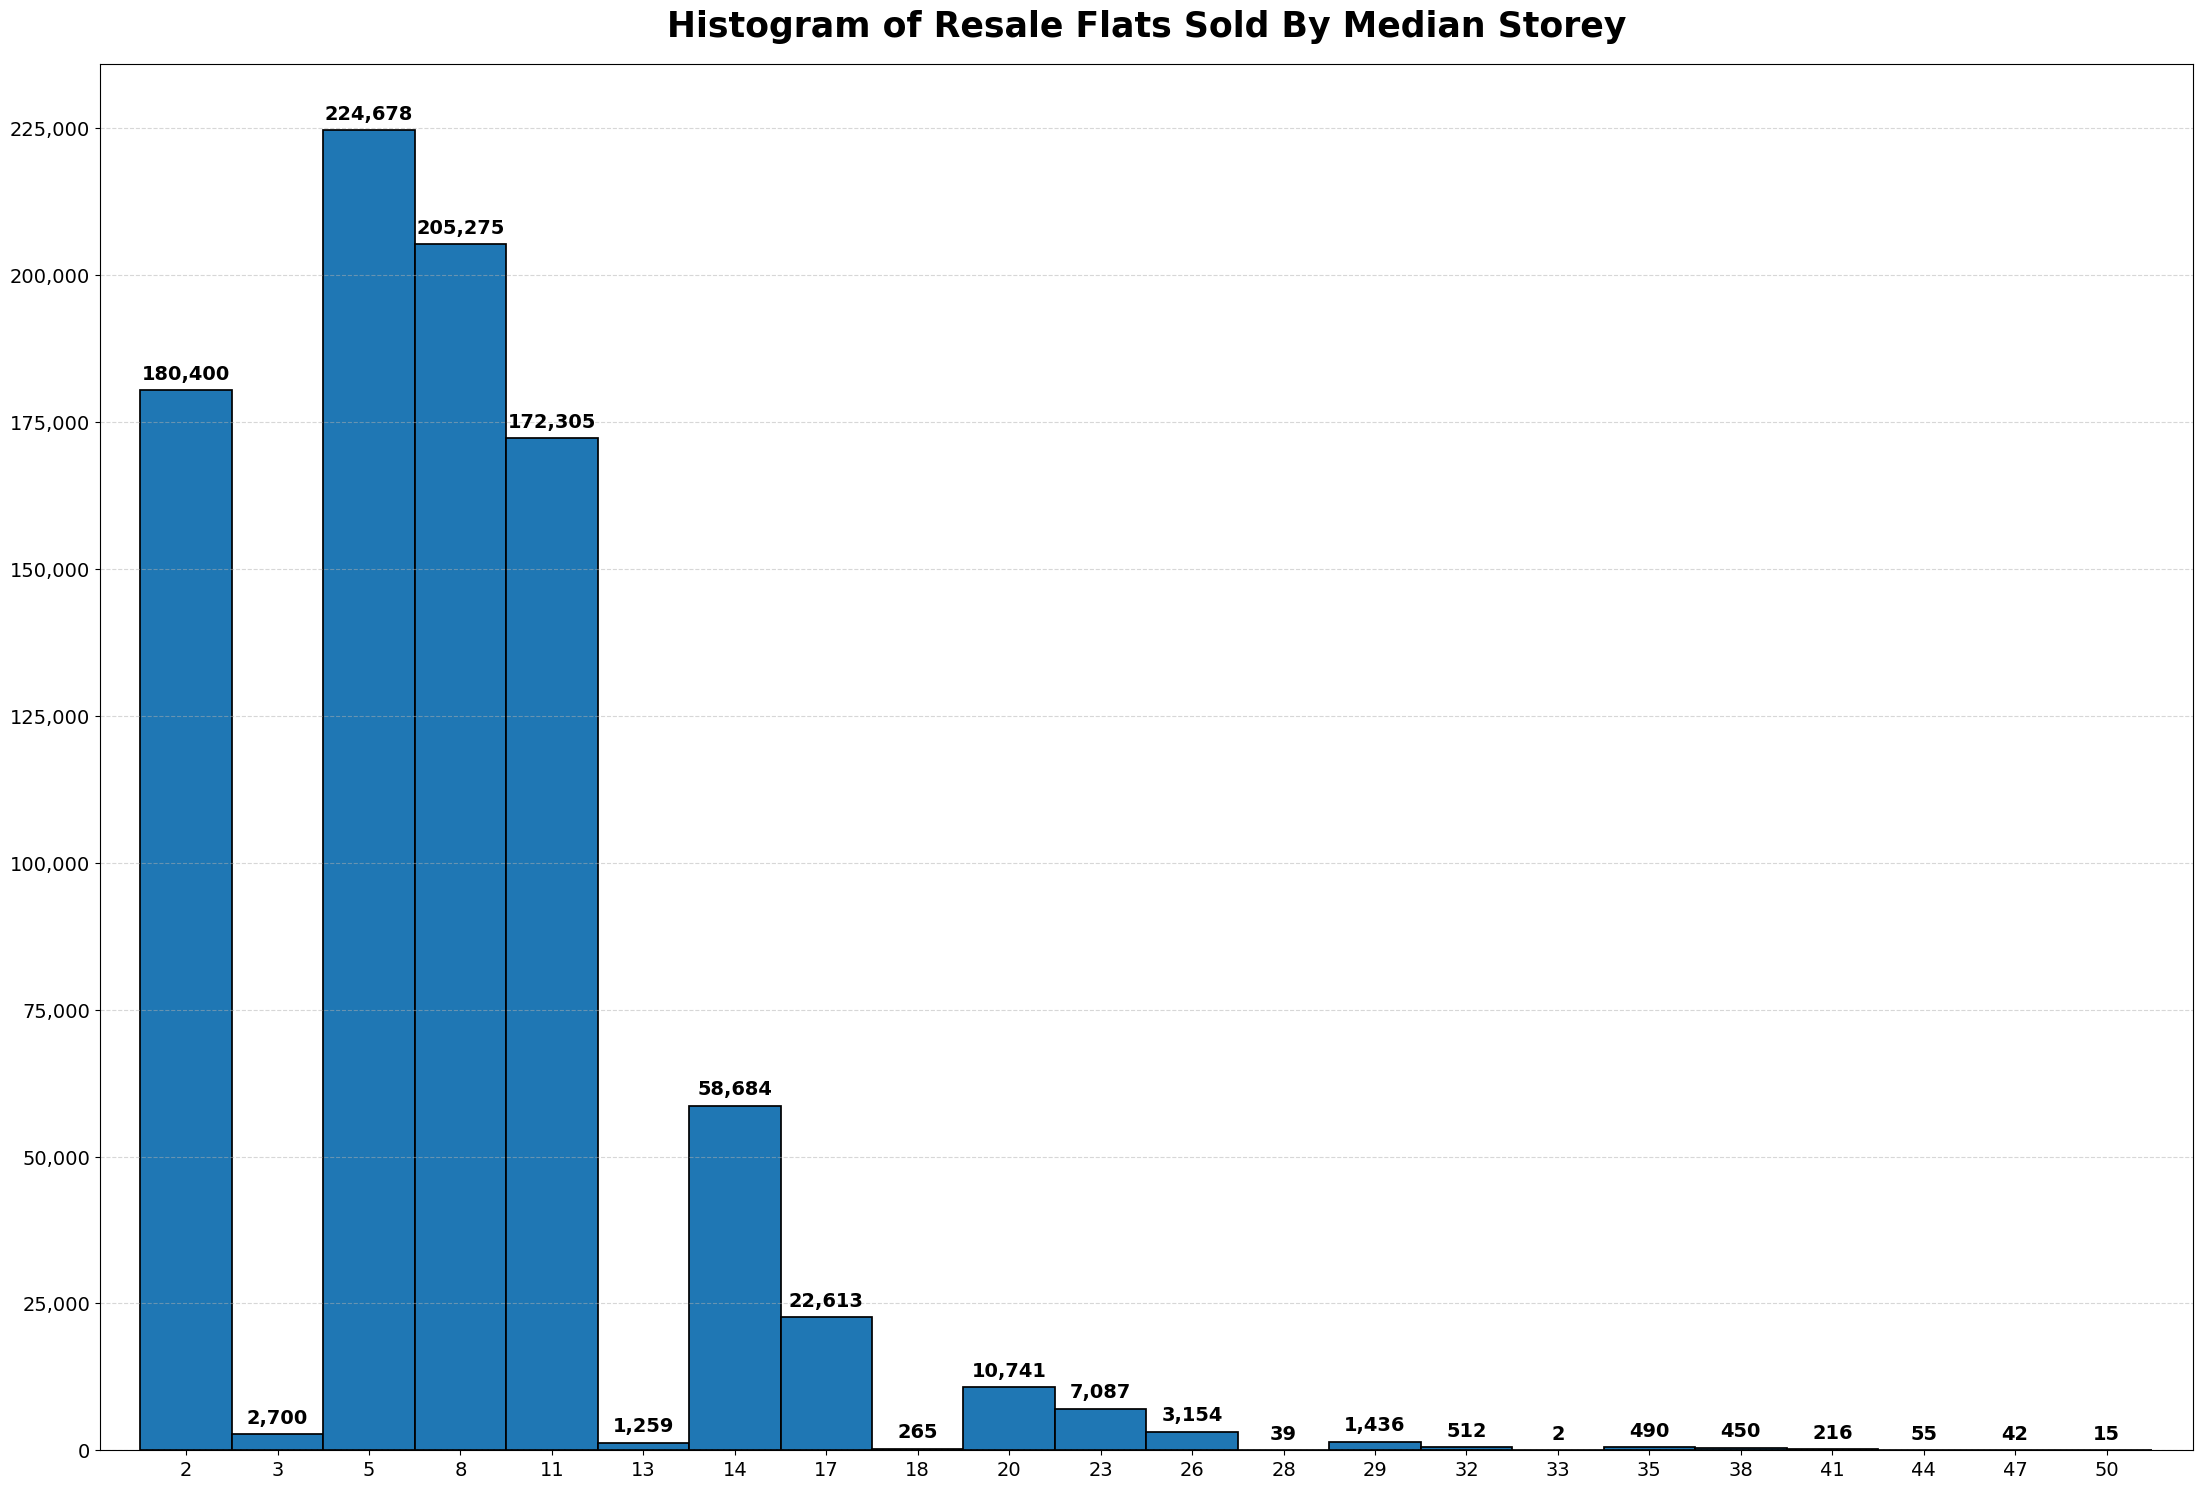

In [9]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
# Convert the median_storey column from a column of integers to a column of strings which acts as a form of a bucket
n, bins, containers = plt.hist([str(median_storey) for median_storey in sorted(HDB_resale_flat_prices_combined.median_storey)], bins = 22, 
                               edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flats Sold By Median Storey', size = 25, weight = 'bold', pad = 20)
plt.xticks([(container._x0 + (container._x0 + container._width))/2 for container in containers], sorted(HDB_resale_flat_prices_combined.median_storey.unique()))
plt.yticks(np.linspace(0, 225000, 10))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 14, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Number of Resale Flats Sold By Median Storey.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

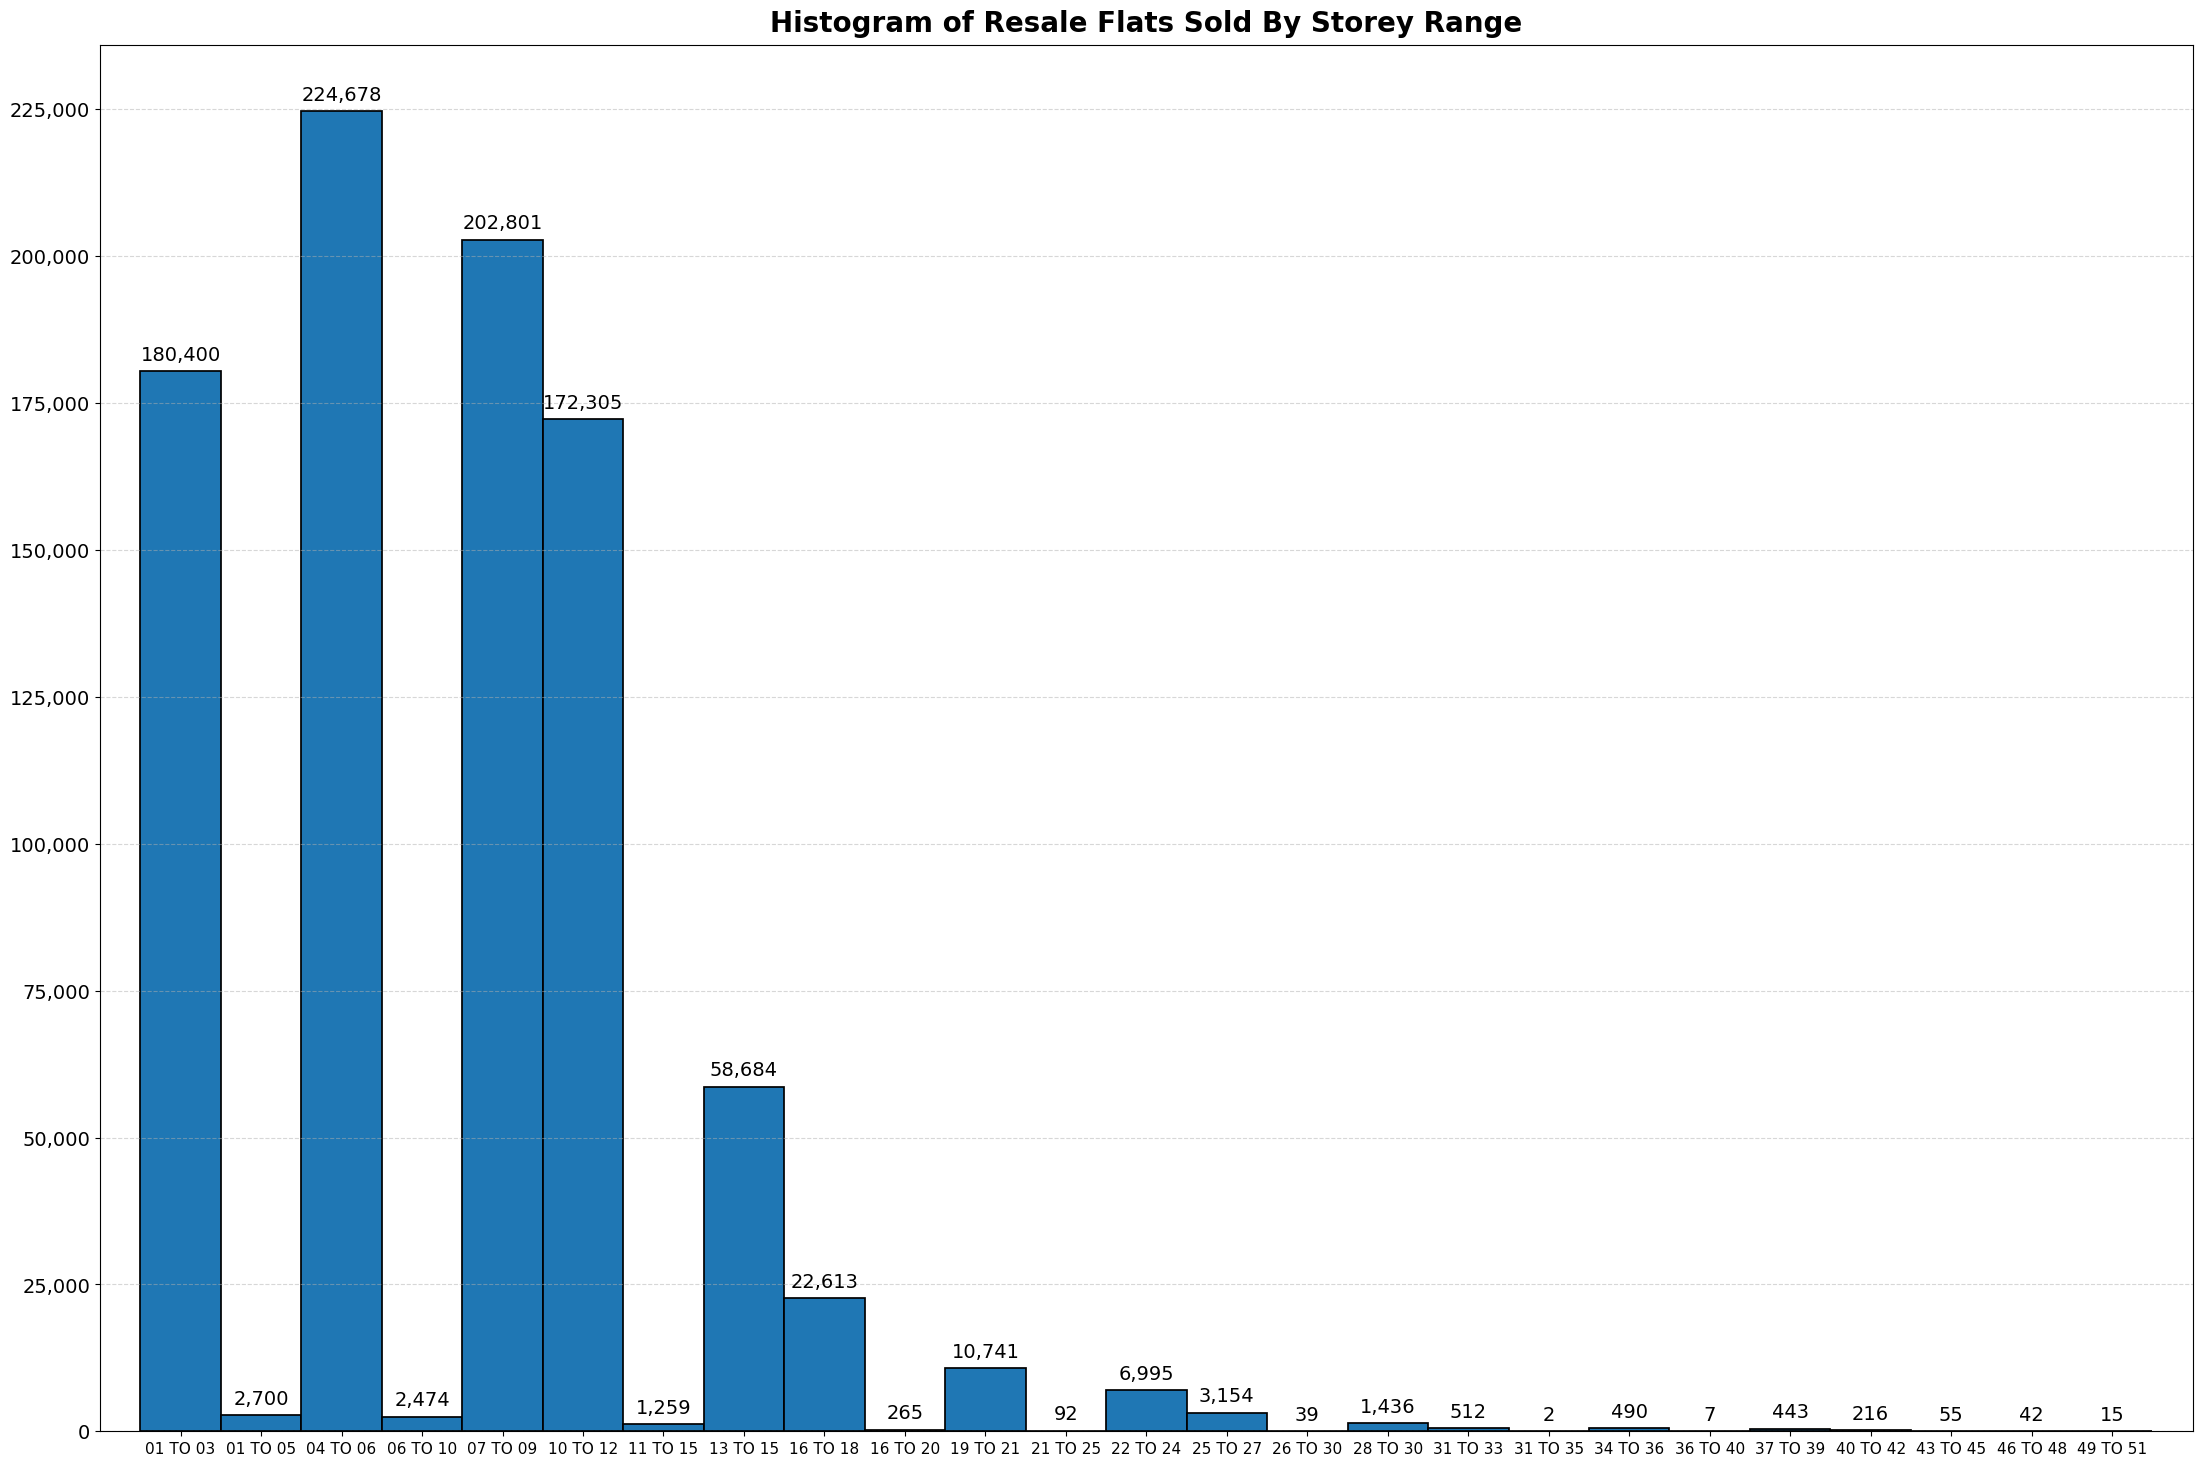

In [10]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.storey_range), bins = 25, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flats Sold By Storey Range', size = 20, weight = 'bold', pad = 10)
plt.xticks([(container._x0 + (container._x0 + container._width))/2 for container in containers], sorted(HDB_resale_flat_prices_combined.storey_range.unique()),
          size = 11)
plt.yticks(np.linspace(0, 225000, 10))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5)
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.show()

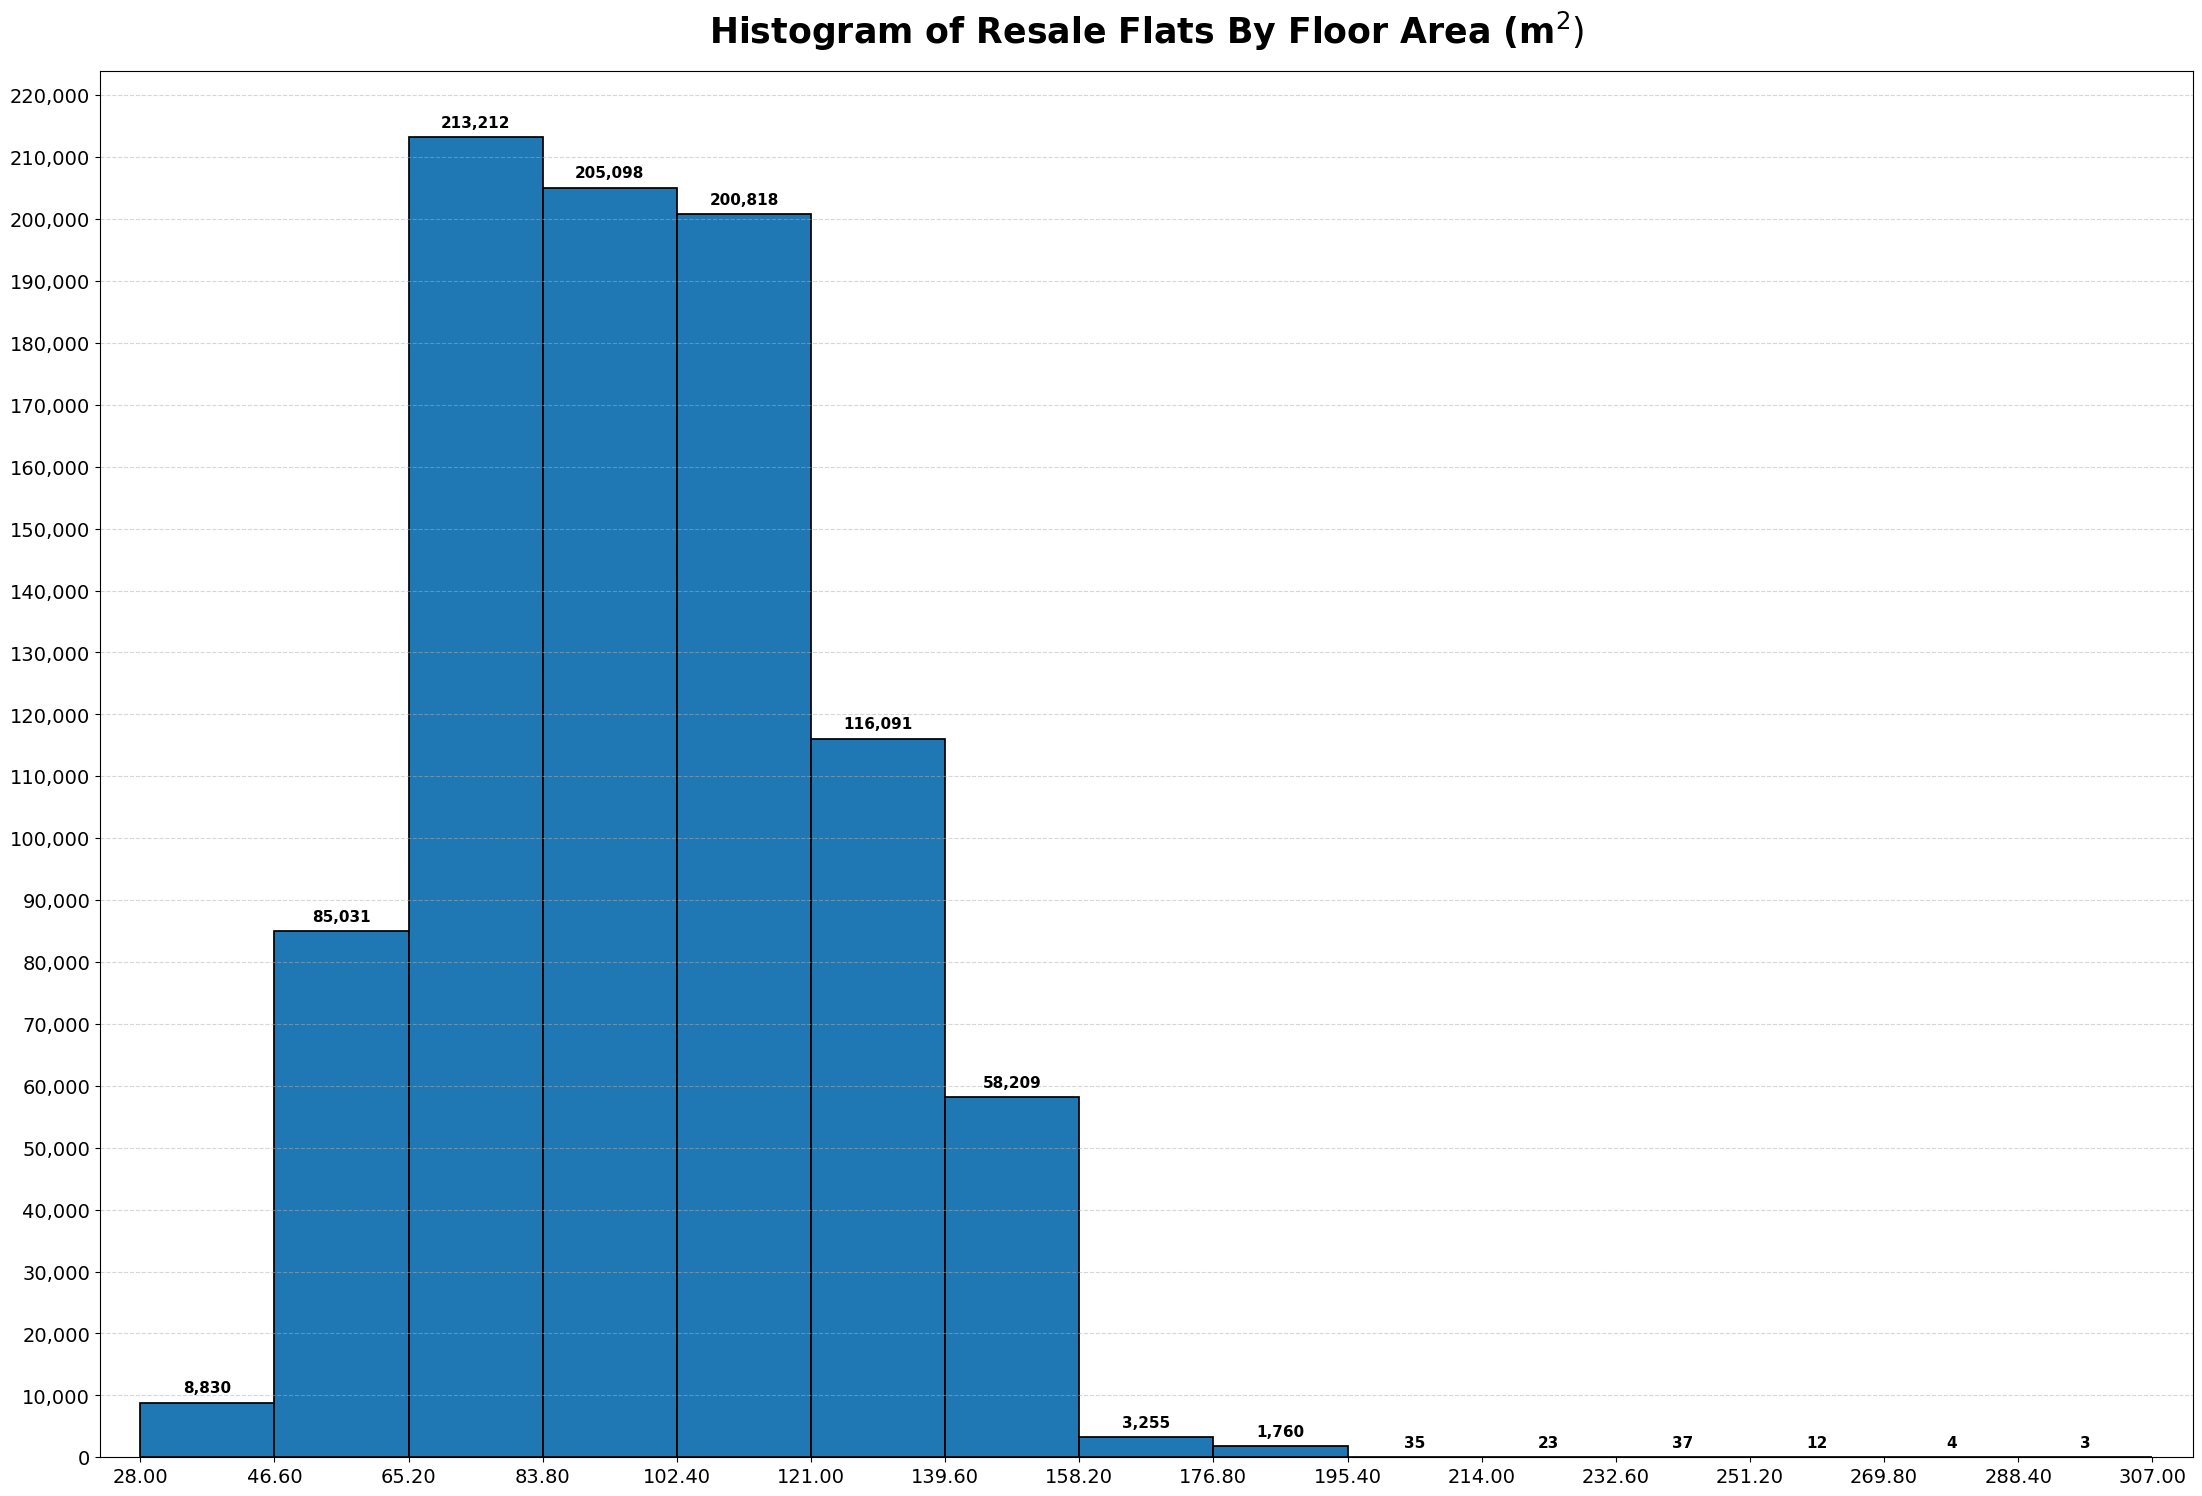

In [11]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.floor_area_sqm), bins = 15, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title(r'Histogram of Resale Flats By Floor Area (m$^{2})$', size = 25, weight = 'bold', pad = 20)
plt.xticks(bins)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.2f}'))
plt.yticks(np.linspace(0, 220000, 23))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 11, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Number of Resale Flats Sold By Floor Area (Square Metre).jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

### **Response Variables**

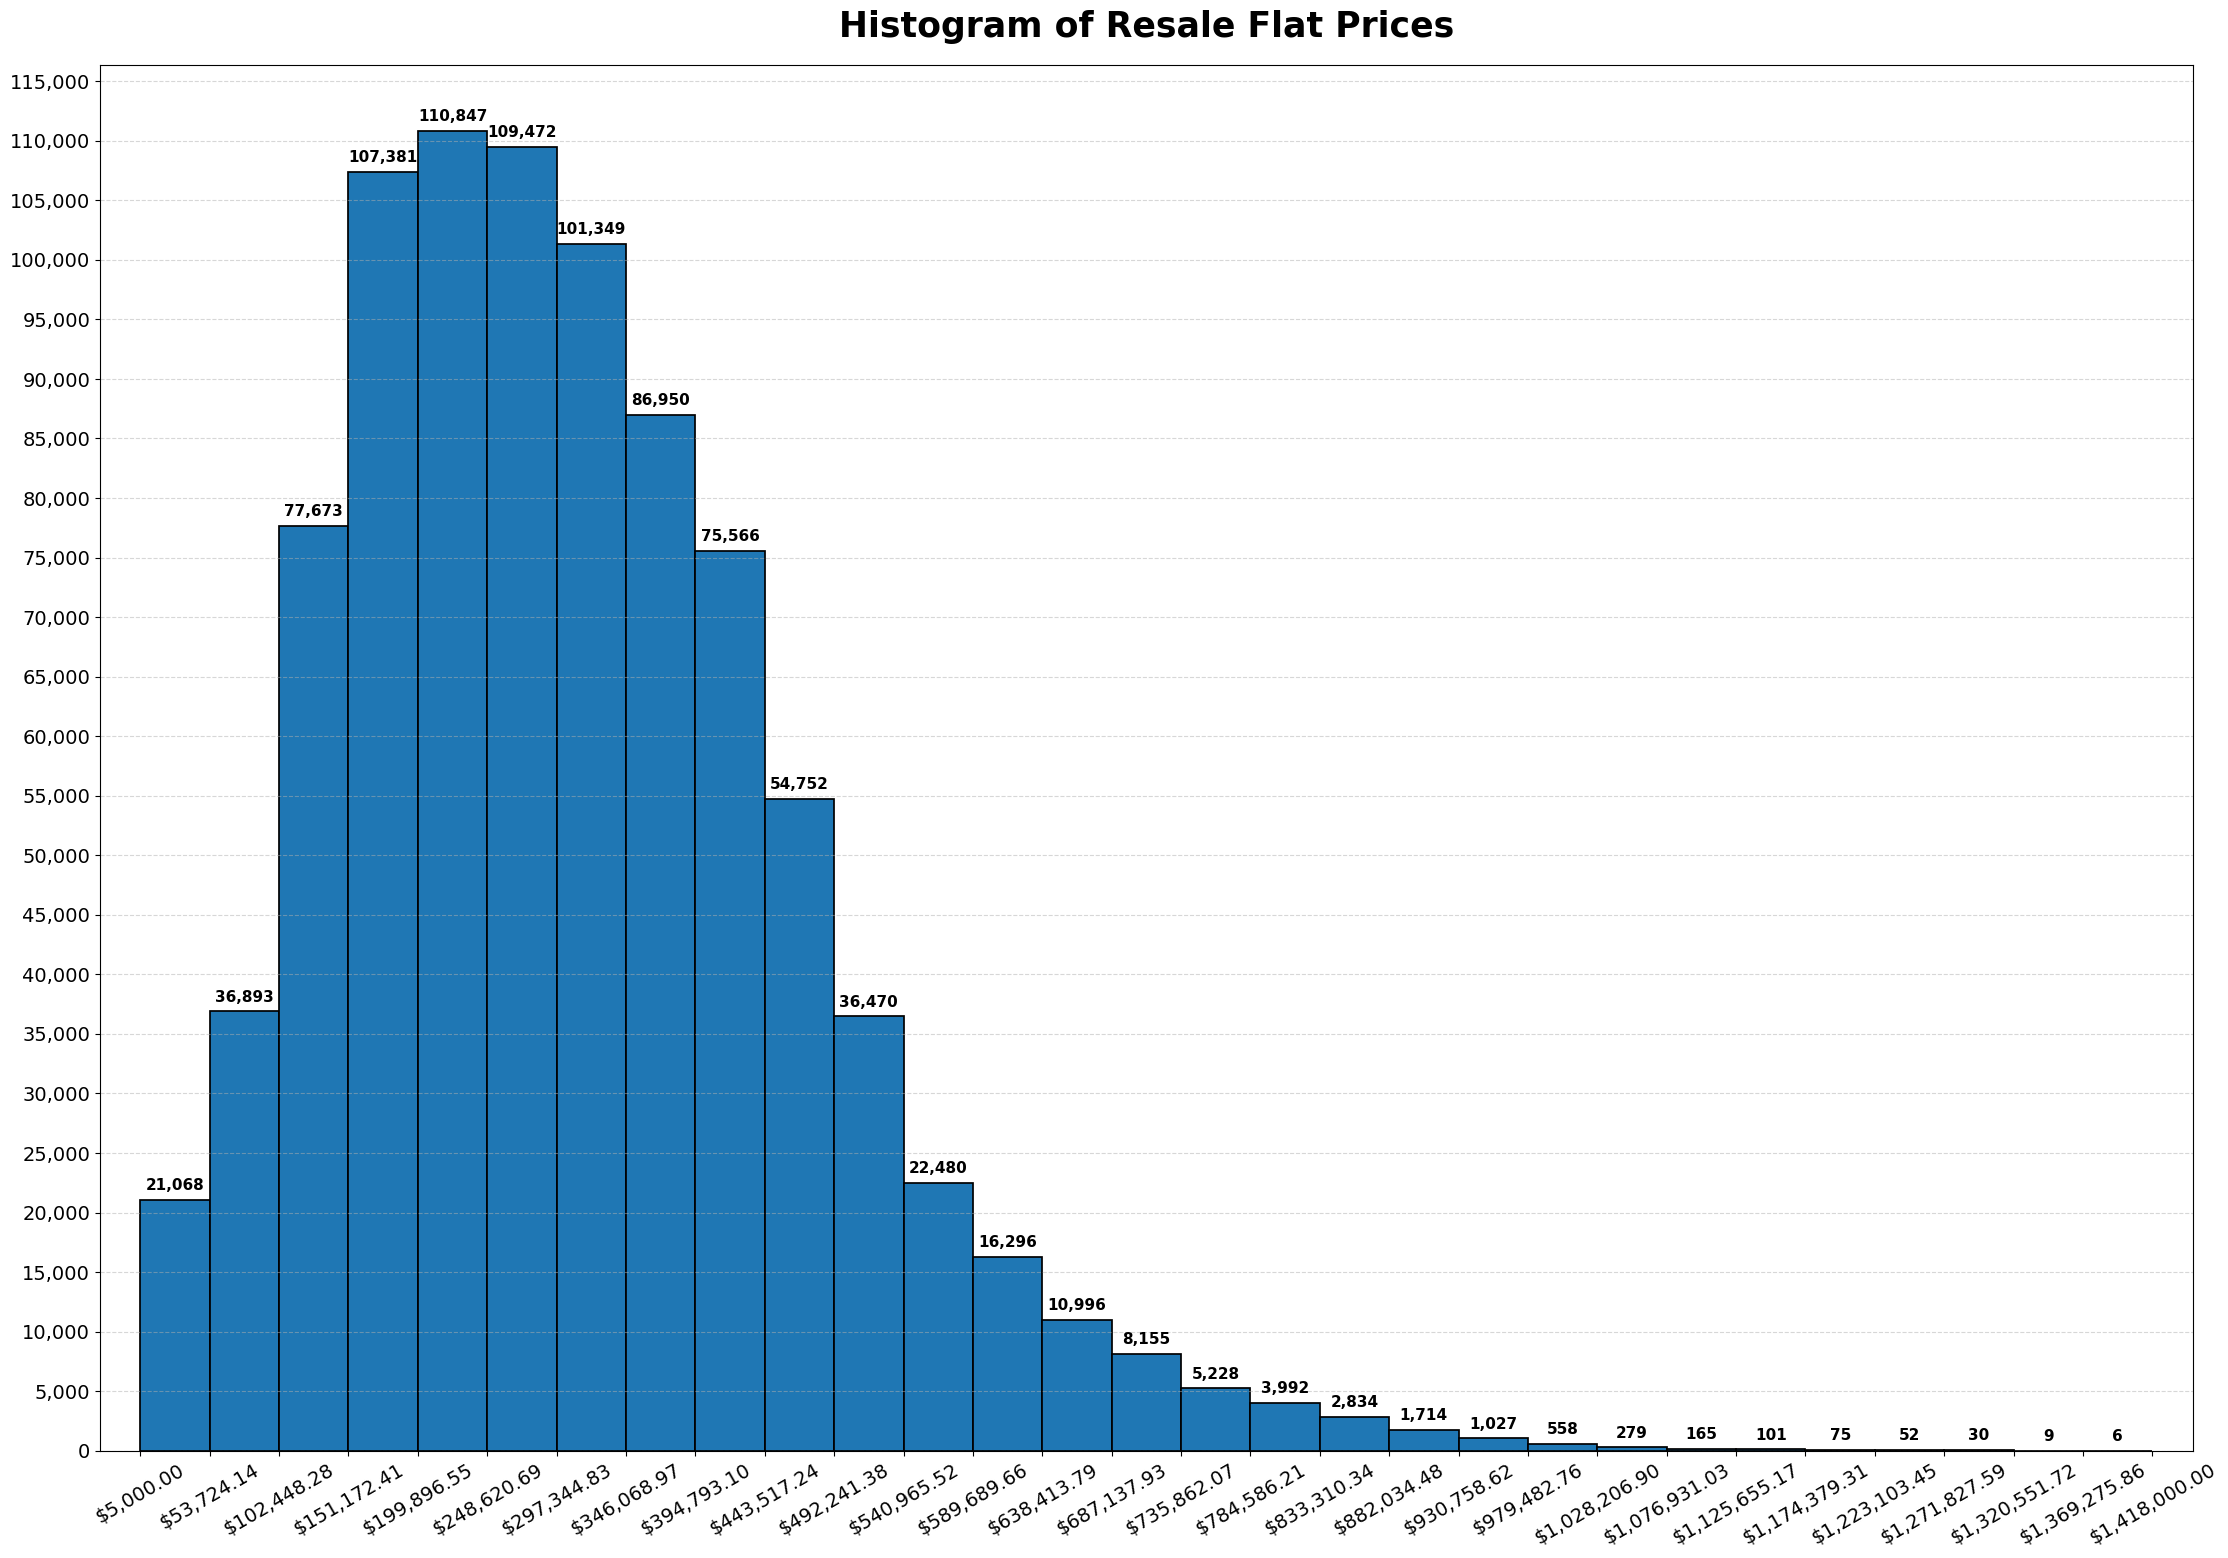

In [12]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.resale_price), bins = 29, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flat Prices', size = 25, weight = 'bold', pad = 20)
plt.xticks(bins, rotation = 30)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.2f}'))
plt.yticks(np.linspace(0, 115000, 24))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 11, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Resale Flat Prices.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

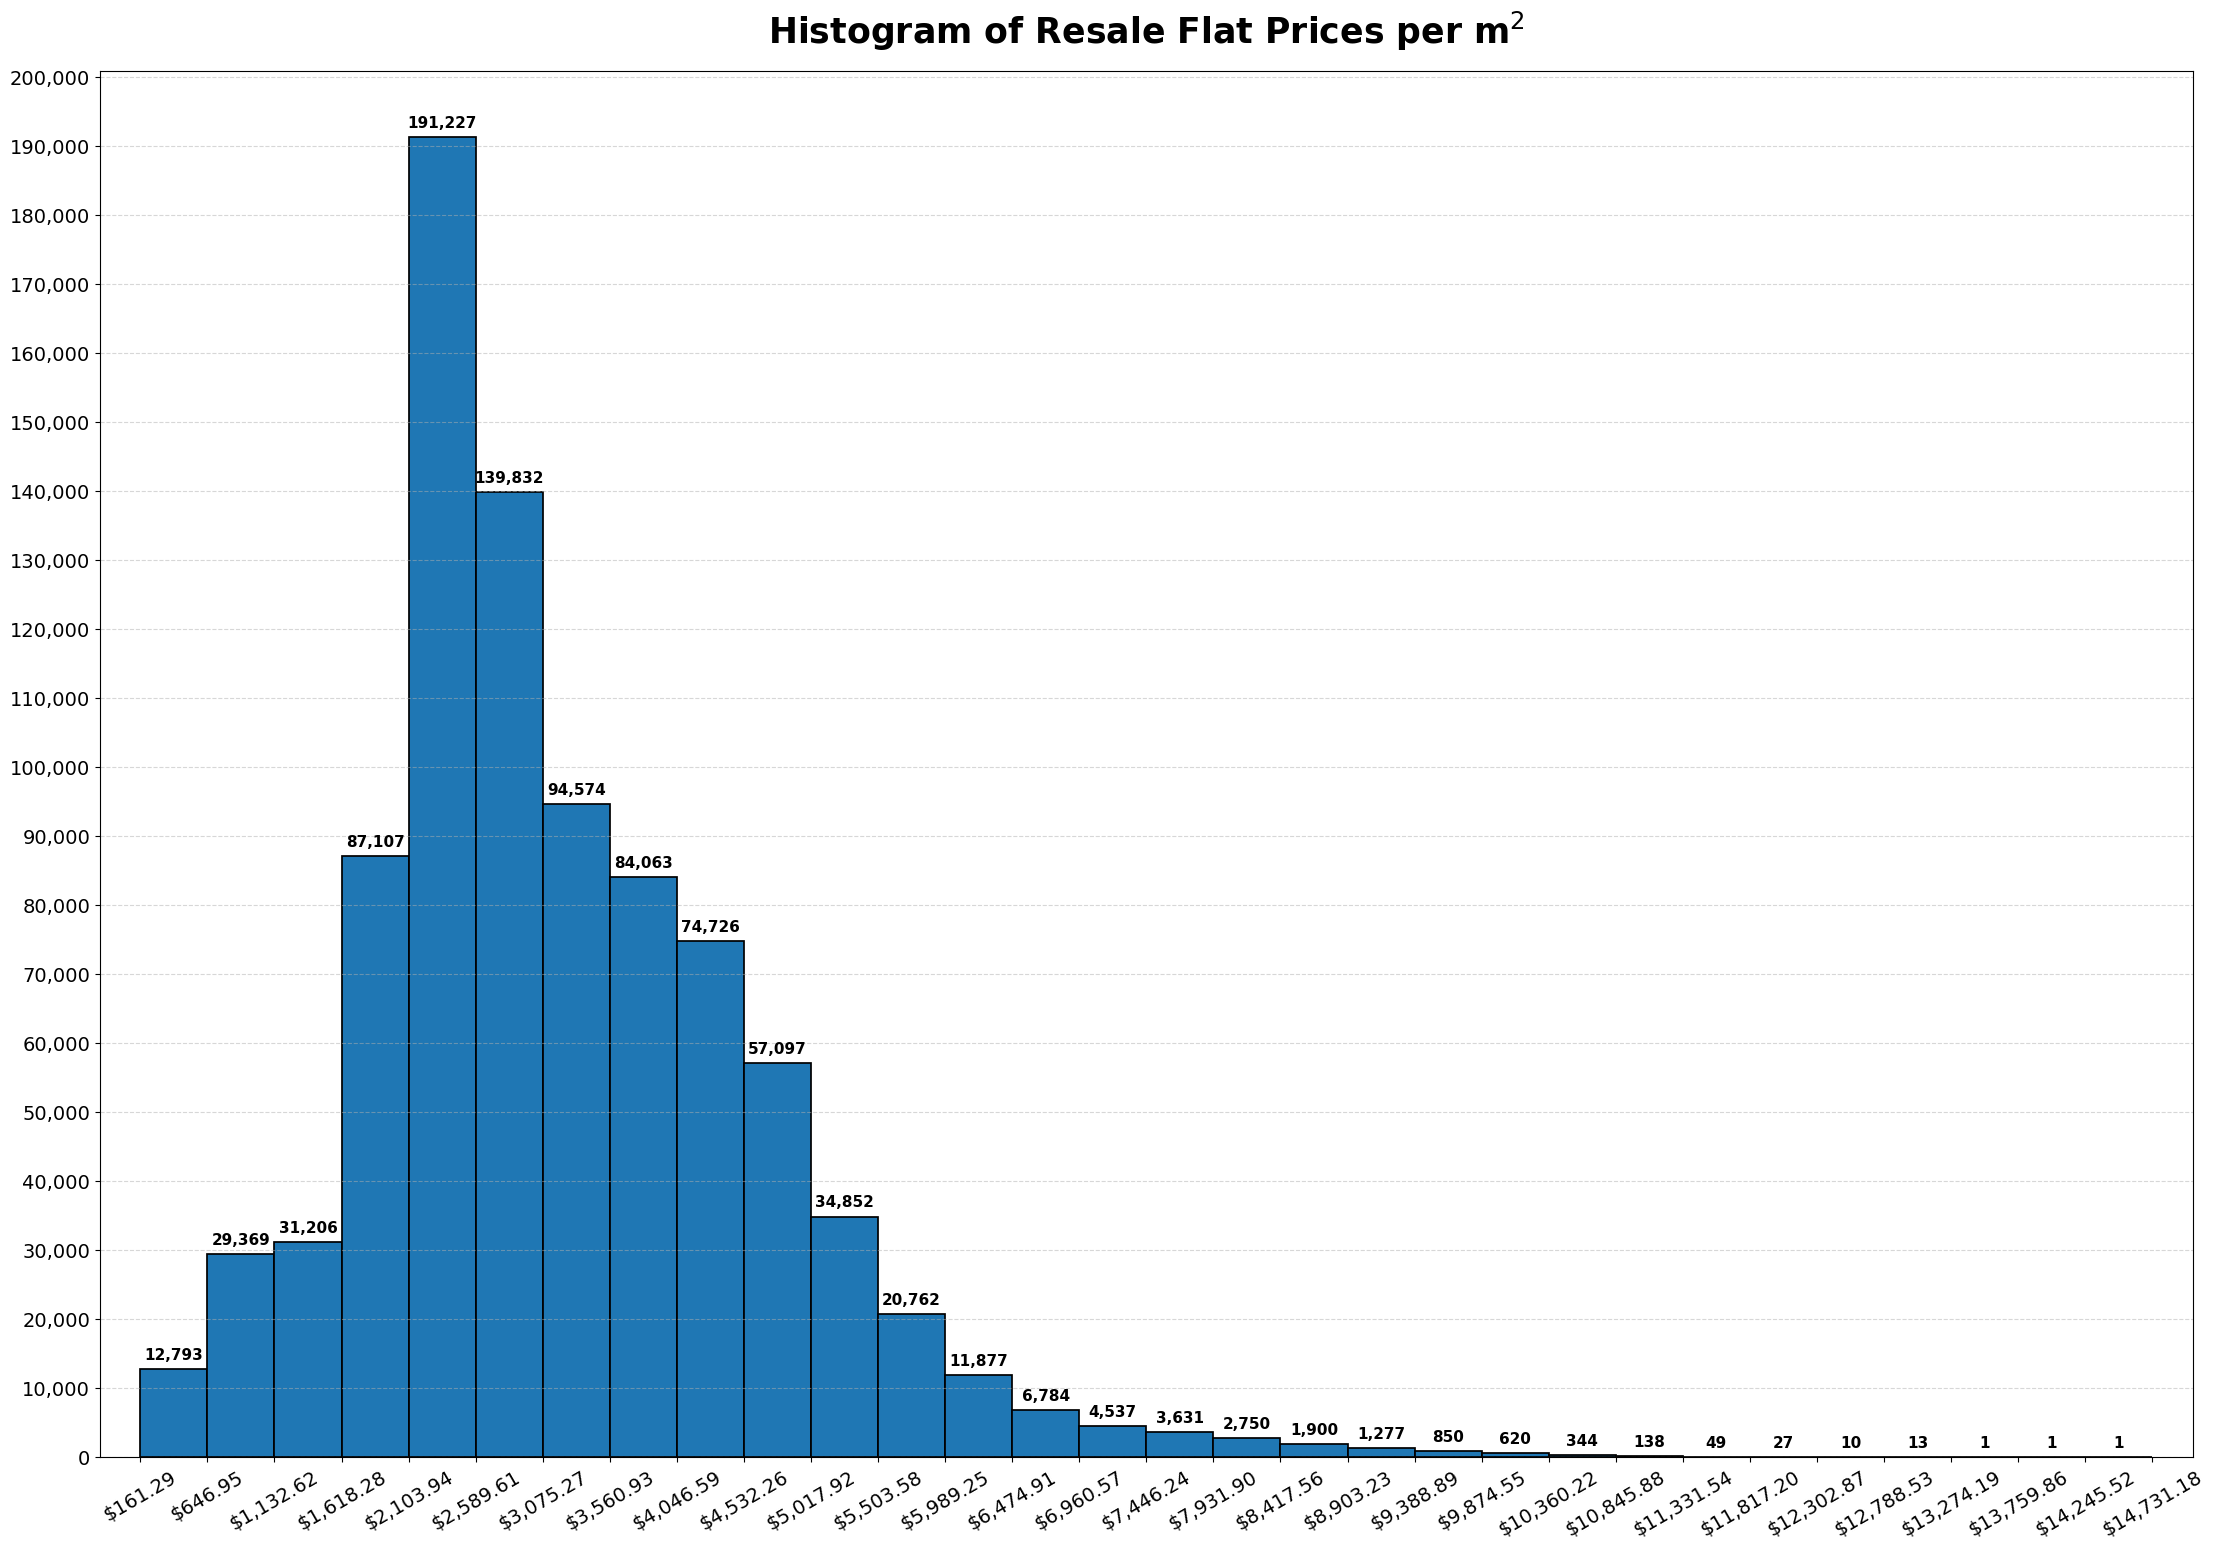

In [13]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.resale_price_per_sqm), bins = 30, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title(r'Histogram of Resale Flat Prices per m$^{2}$', size = 25, weight = 'bold', pad = 20)
plt.xticks(bins, rotation = 30)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.2f}'))
plt.yticks(np.linspace(0, 200000, 21))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 11, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Resale Flat Prices Per Square Metre.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

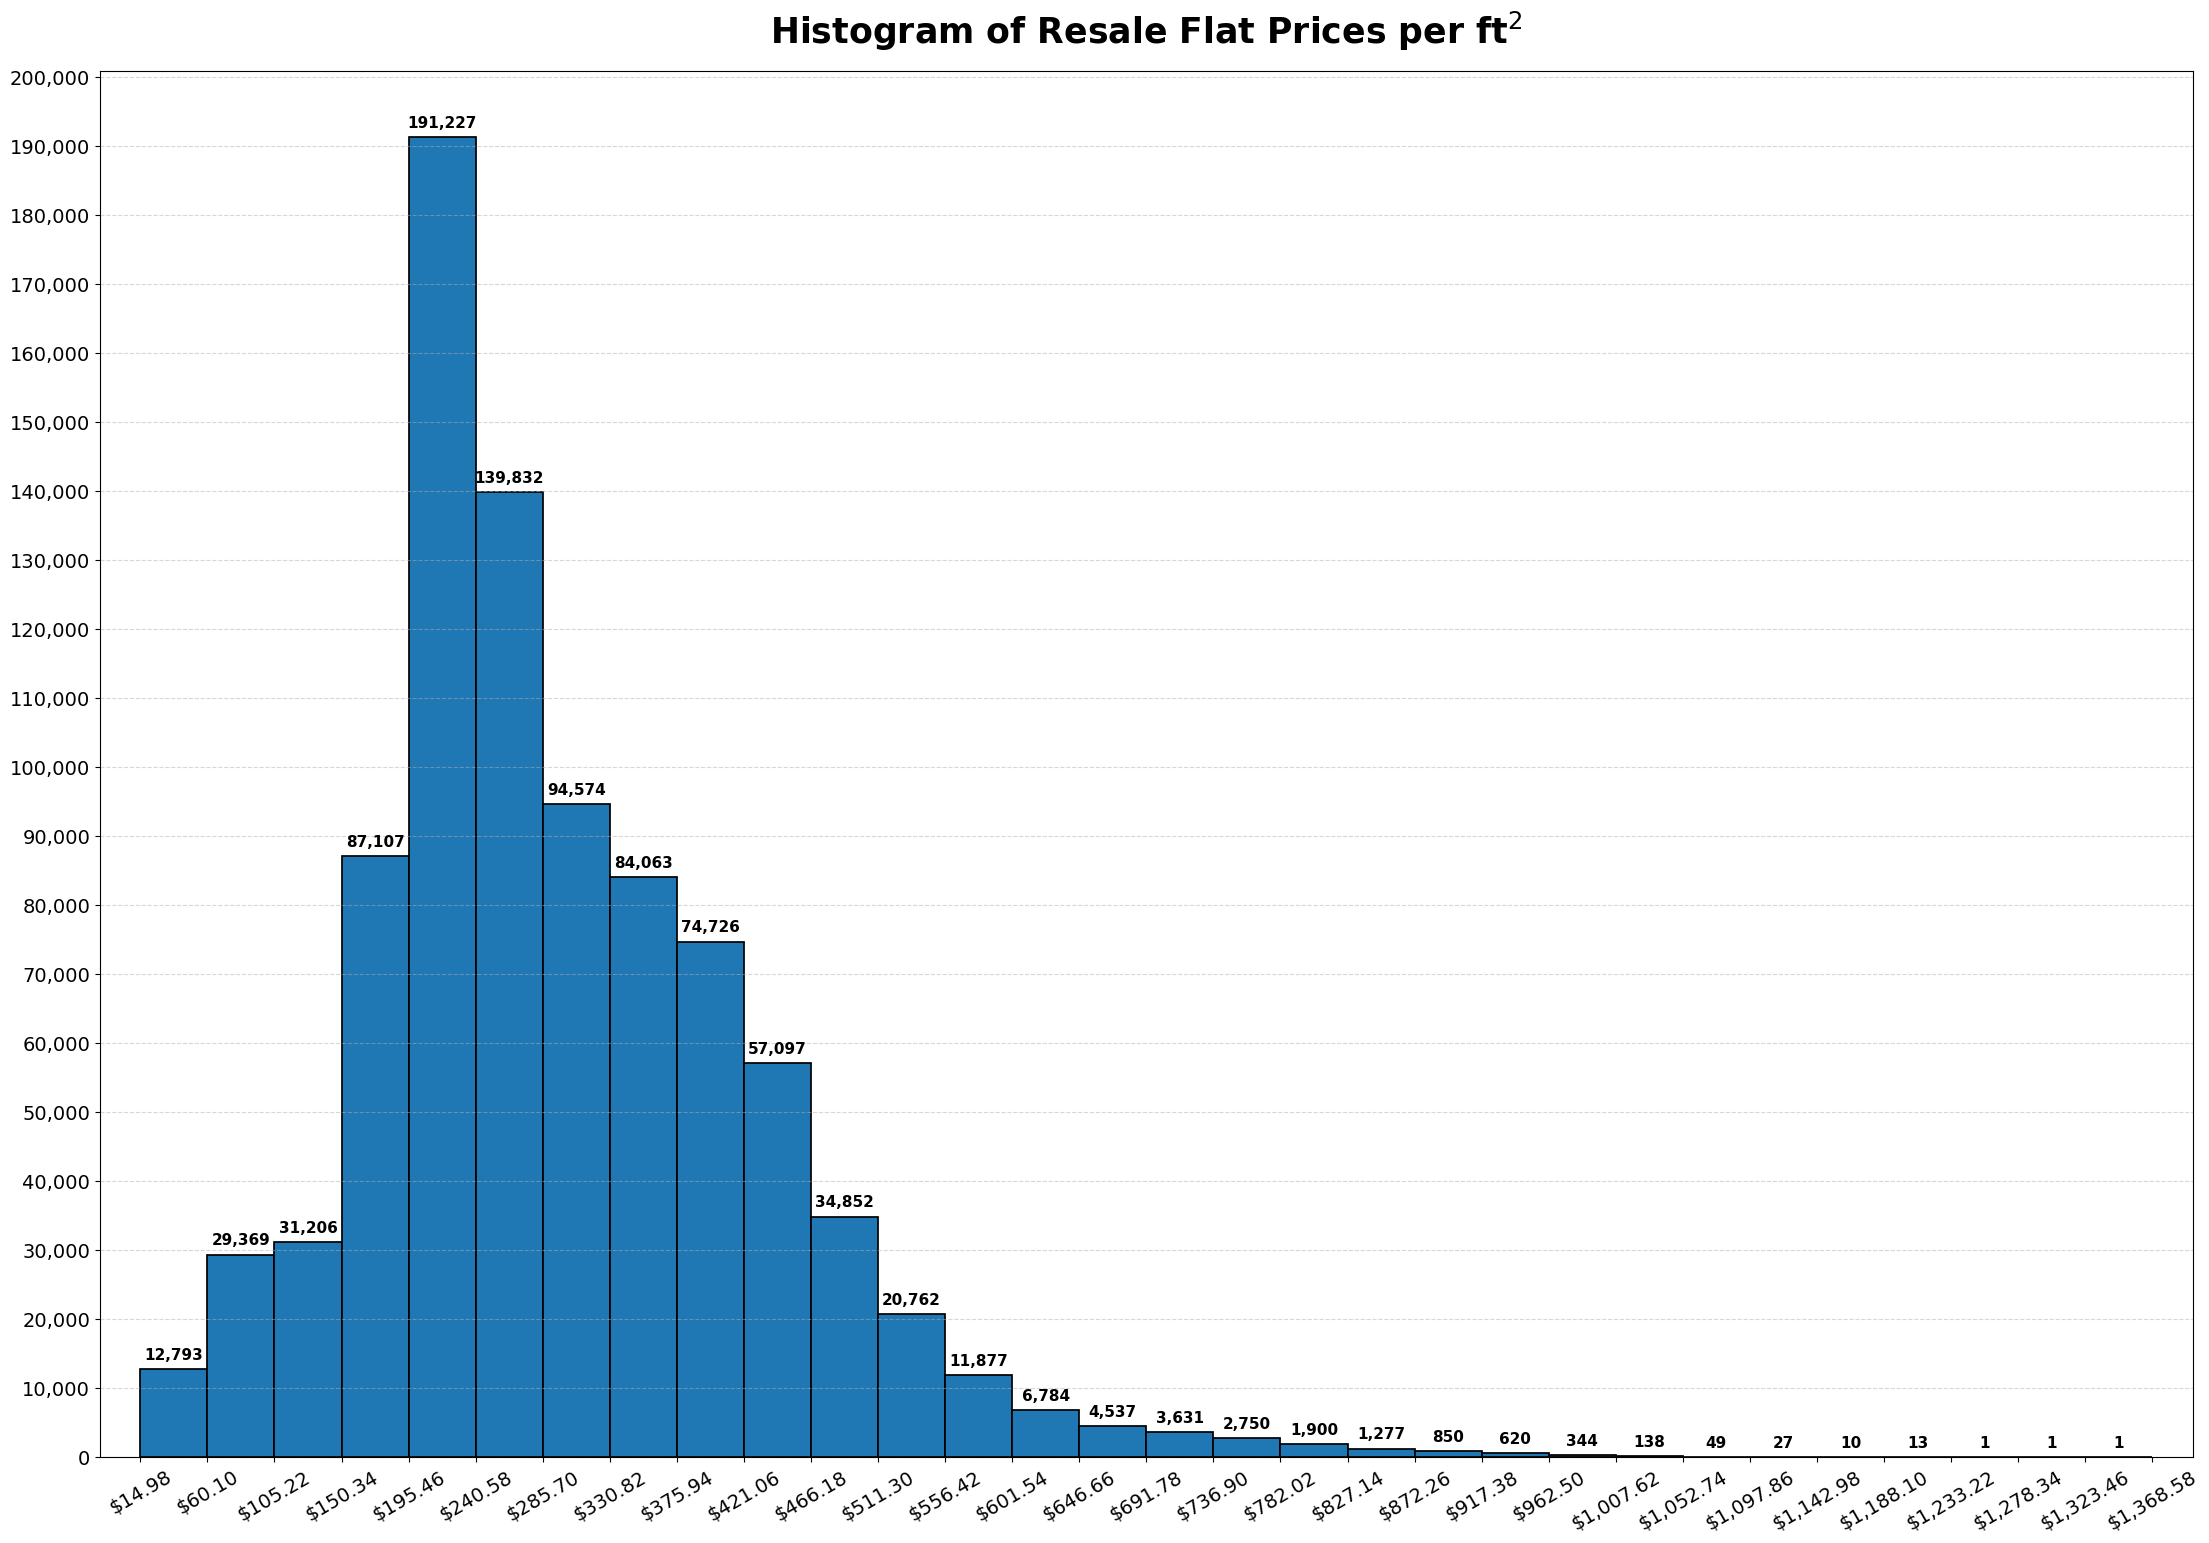

In [14]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.resale_price_per_sqft), bins = 30, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title(r'Histogram of Resale Flat Prices per ft$^{2}$', size = 25, weight = 'bold', pad = 20)
plt.xticks(bins, rotation = 30)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.2f}'))
plt.yticks(np.linspace(0, 200000, 21))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 11, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Resale Flat Prices Per Square Foot.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

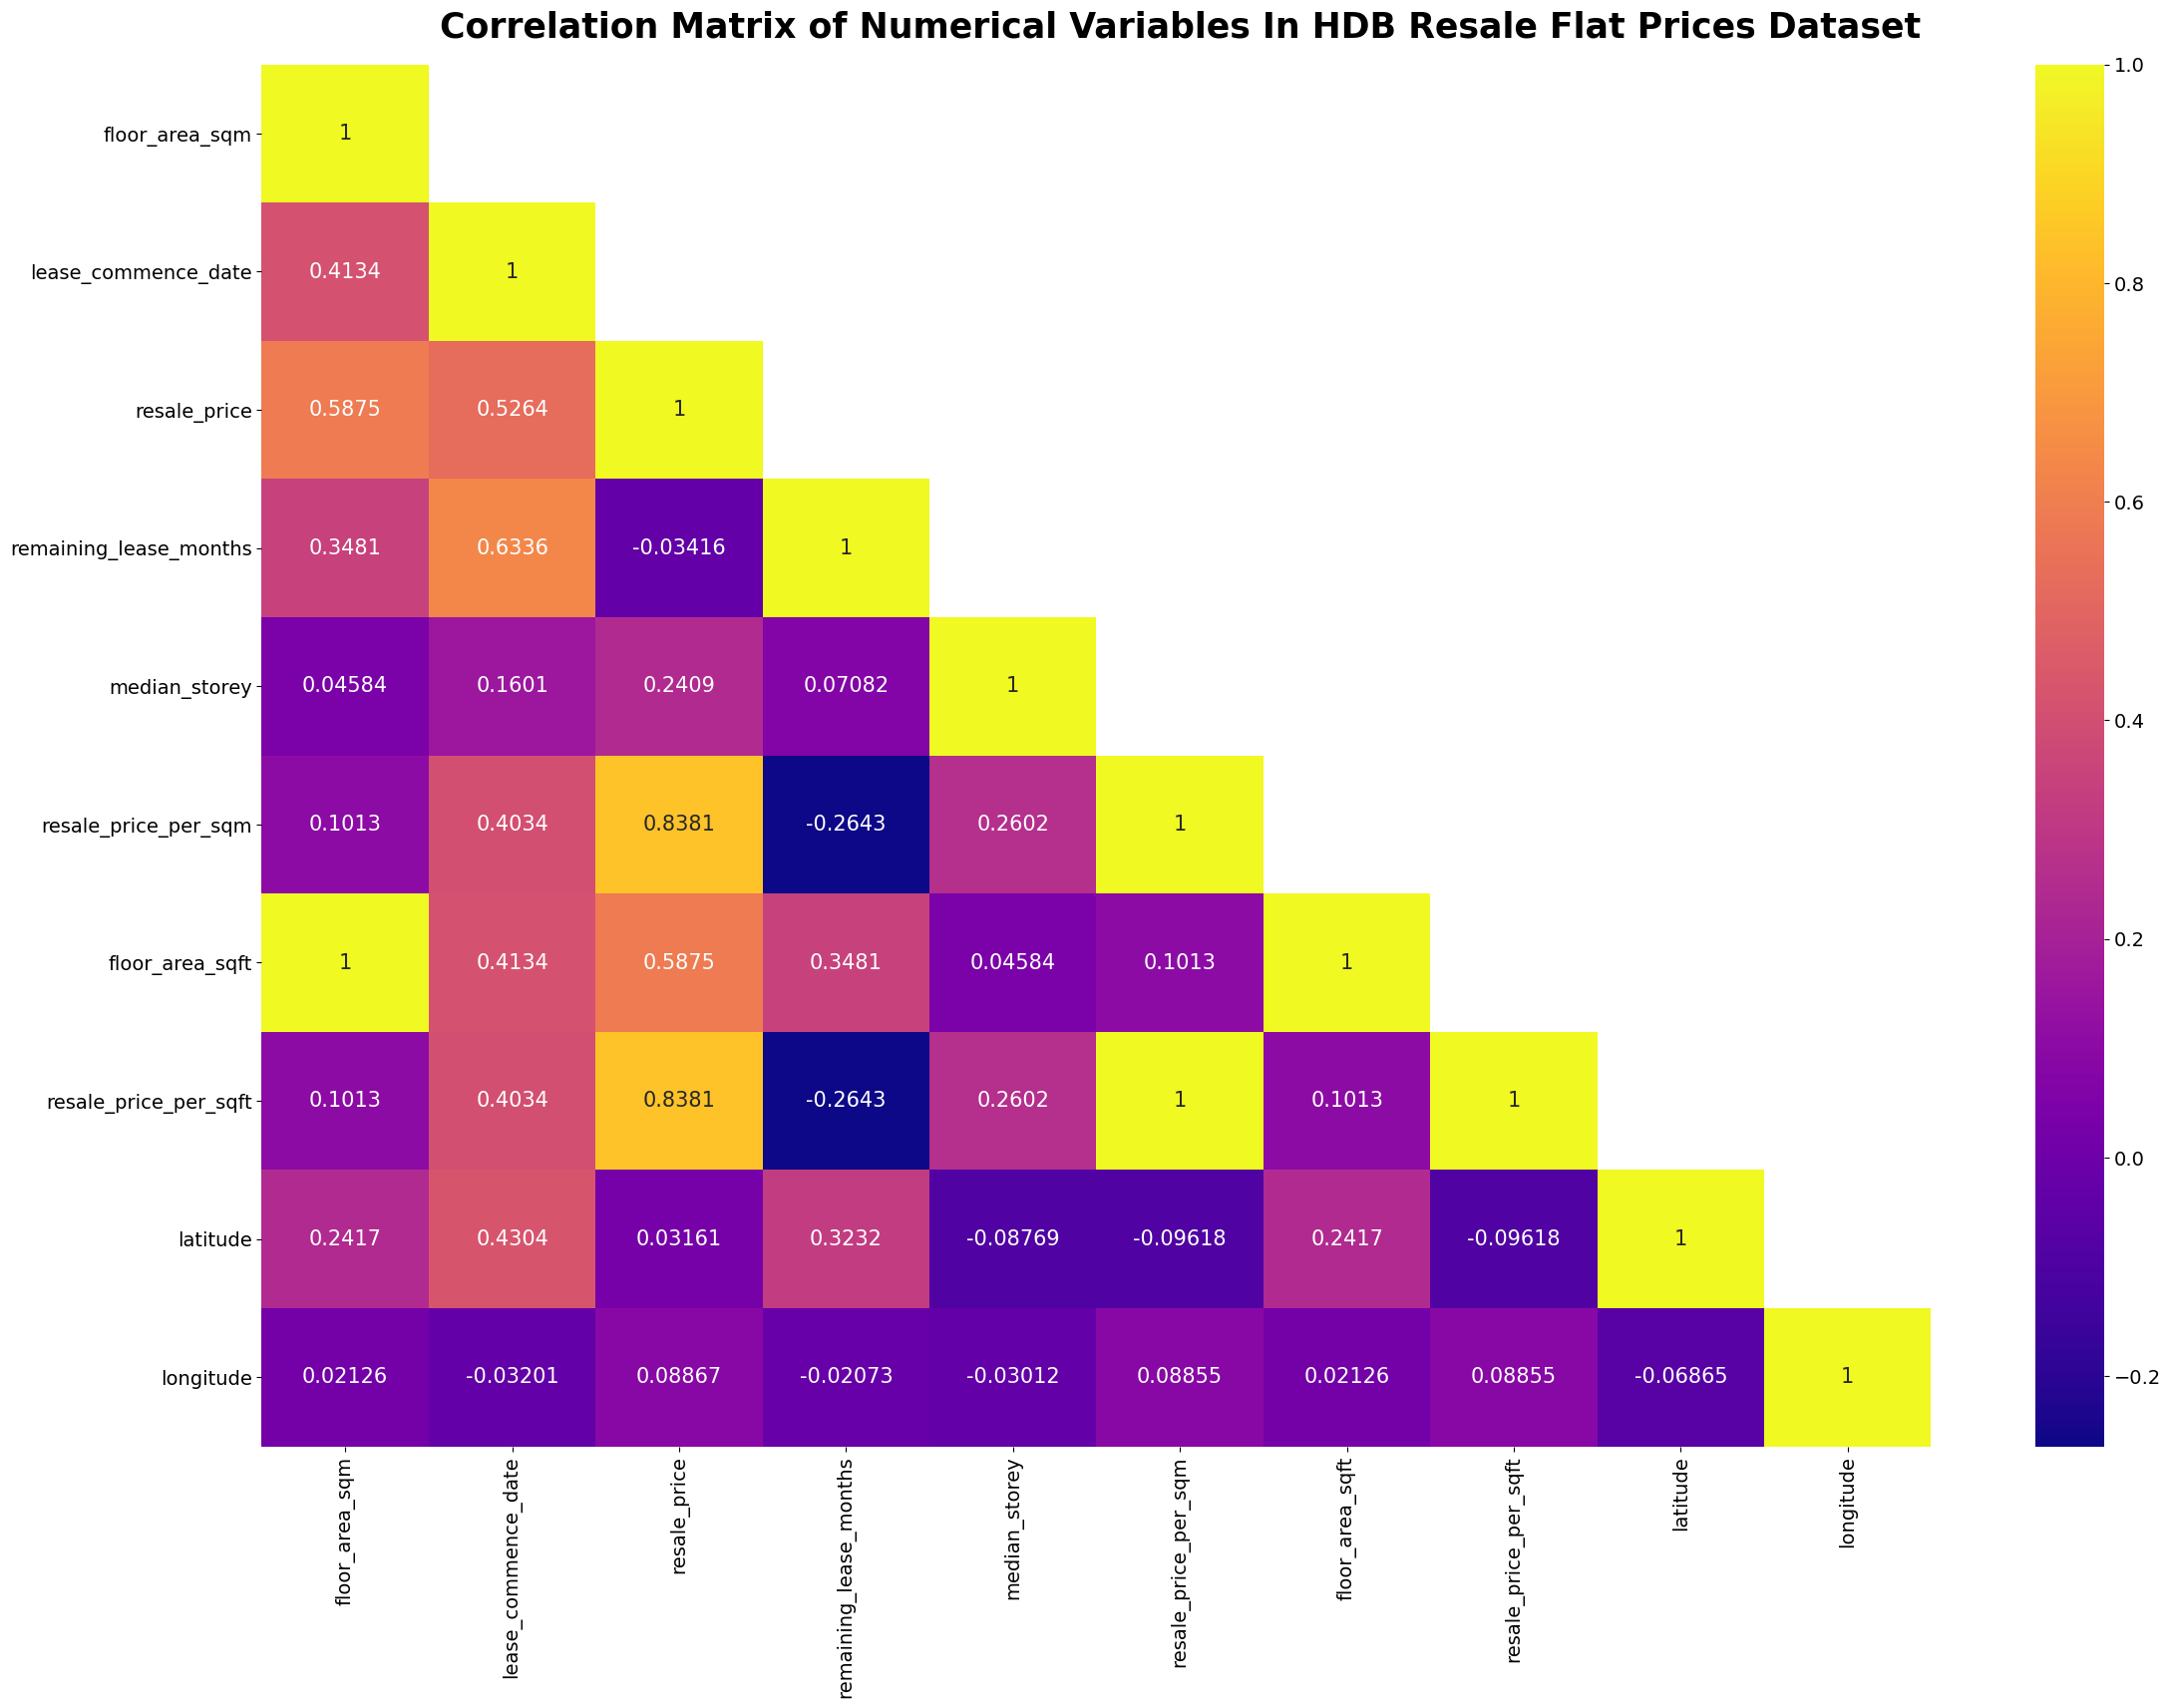

In [15]:
HDB_resale_flat_prices_combined_corr_matrix = HDB_resale_flat_prices_combined.loc[:, HDB_resale_flat_prices_combined.columns != "remaining_lease"].corr(numeric_only = True)
plt.figure(figsize = (27, 18))
plt.title('Correlation Matrix of Numerical Variables In HDB Resale Flat Prices Dataset', size = 25, weight = 'bold', pad = 20, x = 0.55)
plt.xticks(size = 14)
plt.yticks(size = 14)
sns.heatmap(HDB_resale_flat_prices_combined_corr_matrix.where(np.tril(np.ones_like(HDB_resale_flat_prices_combined_corr_matrix, dtype = bool))), 
            cmap = 'plasma', annot = True, fmt = '.4g', annot_kws = {"size": 15})
plt.savefig('Plots/Correlation Matrix.jpeg', dpi = 600, bbox_inches = 'tight')

# **Feature Selection And Data Preparation Prior To Predictive Modelling**

In [16]:
HDB_resale_flat_features = HDB_resale_flat_prices_combined[['town', 'region', 'address', 'latitude', 'longitude', 'remaining_lease_months', 
                                                            'median_storey', 'flat_model_standardized', 'flat_type_standardized', 'floor_area_sqm']]
HDB_resale_flat_features.columns = ['Town', 'Region', 'Address', 'Latitude', 'Longitude', 'Remaining Lease (Months)', 'Median Storey No.', 'Flat Model', 
                                    'Flat Type', 'Floor Area (Square Metres)']
HDB_resale_flat_prices = HDB_resale_flat_prices_combined['resale_price']
HDB_resale_flat_prices.column = 'Resale Price'
feature_datatypes = {'Town': 'category', 'Region': 'category', 'Address': 'category', 'Latitude': 'float64', 'Longitude': 'float64', 'Remaining Lease (Months)': 'int64', 
                     'Median Storey No.': 'int64', 'Flat Model': 'category', 'Flat Type': 'category', 'Floor Area (Square Metres)': 'float64'}
HDB_resale_flat_features = HDB_resale_flat_features.astype(feature_datatypes)
HDB_resale_flat_features.info()
HDB_resale_flat_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892418 entries, 0 to 892417
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Town                        892418 non-null  category
 1   Region                      892418 non-null  category
 2   Address                     892418 non-null  category
 3   Latitude                    892418 non-null  float64 
 4   Longitude                   892418 non-null  float64 
 5   Remaining Lease (Months)    892418 non-null  int64   
 6   Median Storey No.           892418 non-null  int64   
 7   Flat Model                  892418 non-null  category
 8   Flat Type                   892418 non-null  category
 9   Floor Area (Square Metres)  892418 non-null  float64 
dtypes: category(5), float64(3), int64(2)
memory usage: 39.5 MB
<class 'pandas.core.series.Series'>
RangeIndex: 892418 entries, 0 to 892417
Series name: resale_price
Non-Null Count 

## **Allocating 20% of Processed Dataset For Final Model Evaluation**

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV

HDB_resale_flat_features_train, HDB_resale_flat_features_test, HDB_resale_flat_prices_train, HDB_resale_flat_prices_test = train_test_split(
    HDB_resale_flat_features, HDB_resale_flat_prices, test_size = 0.2, random_state = 50)

# **Multiple Linear Regression (multiLR)**

## **Model Building & Training**

In [18]:
import time
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression, SGDRegressor

multiLR_start = time.perf_counter()
categorical_transformer = Pipeline(steps = [('One Hot Encoder', OneHotEncoder(handle_unknown = 'infrequent_if_exist'))])
preprocessor = ColumnTransformer(transformers = [('Categorical Transformer', categorical_transformer, make_column_selector(dtype_include = 'category'))], 
                                 remainder = 'passthrough')
multiLR_pipeline = Pipeline(steps = [('Preprocessor', preprocessor), ('Standard Scaler', StandardScaler(with_mean = False)), 
                                     ('Multiple Linear Regression', LinearRegression(n_jobs = -1))])
multiLR_pipeline.fit(HDB_resale_flat_features_train, HDB_resale_flat_prices_train)
multiLR_training_duration = time.perf_counter() - multiLR_start

In [19]:
multiLR_pipeline

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Categorical Transformer',
                                                  Pipeline(steps=[('One Hot '
                                                                   'Encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x185299540>)])),
                ('Standard Scaler', StandardScaler(with_mean=False)),
                ('Multiple Linear Regression', LinearRegression(n_jobs=-1))])

## **Model Evaluation Using Root Mean Squared Error (RMSE) & Adjusted $R^{2}$**

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

multiLR_prediction = pd.Series(multiLR_pipeline.predict(HDB_resale_flat_features_test))
multiLR_rmse = mean_squared_error(HDB_resale_flat_prices_test, multiLR_prediction, squared = False)
multiLR_r2 = r2_score(HDB_resale_flat_prices_test, multiLR_prediction, multioutput = 'variance_weighted')

## **Tracking The Performance Metrics of Each Model In A DataFrame**

In [21]:
performance_metrics = pd.DataFrame(columns = ['Model', 'Training Duration', 'RMSE', 'Adjusted R-Squared'])
performance_metrics.loc['Basic Linear Regression'] = ['Basic Multiple Linear Regression', multiLR_training_duration,
                                                      multiLR_rmse, multiLR_r2]
performance_metrics

,Model,Training Duration,RMSE,Adjusted R-Squared
Basic Linear Regression,Basic Multiple Linear Regression,3.732169,59482.423531,0.865311


# **Basic Decision Tree Regression (DTR)**

## **Hyperparameter Tuning To Find The Decision Tree Model Having The Optimal Max Depth**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

DTR_start = time.perf_counter()
DTR_pipeline = Pipeline(steps = [('Preprocessor', preprocessor), ('Standard Scaler', StandardScaler(with_mean = False)), 
                                 ('DecisionTreeRegressor', DecisionTreeRegressor(random_state = 50))])
DTR_hyperparam_grid = {'DecisionTreeRegressor__max_depth': np.linspace(start = 50, stop = 100, num = 26, dtype = int)}
DTR_with_GridSearch = GridSearchCV(estimator = DTR_pipeline, param_grid = DTR_hyperparam_grid, scoring = 'neg_root_mean_squared_error', 
                                   cv = 8, n_jobs = -1, return_train_score = True)
DTR_with_GridSearch.fit(HDB_resale_flat_features_train, HDB_resale_flat_prices_train)
DTR_train_duration = time.perf_counter() - DTR_start

In [ ]:
DTR_best_prediction = pd.Series(DTR_with_GridSearch.predict(HDB_resale_flat_features_test))
DTR_best_rmse = mean_squared_error(HDB_resale_flat_prices_test, DTR_best_prediction, squared = False)
DTR_best_r2 = r2_score(HDB_resale_flat_prices_test, DTR_best_prediction, multioutput = 'variance_weighted')

In [ ]:
performance_metrics.loc['Decision Tree Regression'] = ['Decision Tree Regression With Hyperparameter Tuning', 
                                                       DTR_train_duration, DTR_best_rmse, DTR_best_r2]
performance_metrics

In [ ]:
DTR_with_GridSearch.best_estimator_

In [ ]:
DTR_max_depth = []
for hyperparam in DTR_with_GridSearch.cv_results_['params']:
    DTR_max_depth.append(hyperparam['DecisionTreeRegressor__max_depth'])

DTR_mean_train_score = -DTR_with_GridSearch.cv_results_['mean_train_score']
DTR_std_error_train_score = DTR_with_GridSearch.cv_results_['std_train_score']/np.sqrt(len(DTR_with_GridSearch.cv_results_['std_train_score']))

DTR_mean_test_score = -DTR_with_GridSearch.cv_results_['mean_test_score']
DTR_std_error_test_score = DTR_with_GridSearch.cv_results_['std_test_score']/np.sqrt(len(DTR_with_GridSearch.cv_results_['std_test_score']))

plt.figure(figsize = (27, 18))
plt.title('Decision Tree Regression Grid Search Validation Curves', size = 25, weight = 'bold', pad = 20)
plt.plot(DTR_max_depth, DTR_mean_train_score, 'D-', color = 'C1', label = 'Training Scores')
plt.plot(DTR_max_depth, DTR_mean_test_score, 'D-', color = 'C0', label = 'Cross-Validation Scores')

plt.fill_between(DTR_max_depth, DTR_mean_train_score - DTR_std_error_train_score, DTR_mean_train_score + DTR_std_error_train_score,
                 alpha = 0.2, color = 'C1')
plt.fill_between(DTR_max_depth, DTR_mean_test_score - DTR_std_error_test_score, DTR_mean_test_score + DTR_std_error_test_score,
                 alpha = 0.2, color = 'C0')

plt.xlabel('Max Depth', size = 14, labelpad = 15)
plt.xticks(DTR_max_depth)
plt.xlim(np.min(DTR_max_depth), np.max(DTR_max_depth))
plt.ylabel('Root Mean Squared Error (RMSE)', size = 14, labelpad = 15)
plt.yticks(np.linspace(7500, 37500, 13))
plt.ylim(6000, 38000)
plt.legend(loc = 'best', fontsize = 14)
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Validation Curves/Decision Tree Regression With Hyperparameter Tuning Using Grid Search.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [ ]:
DTR_cv_test_results = pd.DataFrame({'Max Depth': DTR_max_depth, 'Mean Train RMSE': DTR_mean_train_score, 'Train RMSE Standard Error': DTR_std_error_train_score, 
                                    'Mean CV RMSE': DTR_mean_test_score, 'Test CV Standard Error': DTR_std_error_test_score})
DTR_cv_test_results

# **Random Forest Regression (RFR)**

In [27]:
from sklearn.ensemble import RandomForestRegressor

RFR_start = time.perf_counter()
RFR_pipeline = Pipeline(steps = [('Preprocessor', preprocessor), ('Standard Scaler', StandardScaler(with_mean = False)), 
                                 ('RandForestRegressor', RandomForestRegressor(random_state = 50, n_jobs = -1, max_samples = 0.4, verbose = 2))])
RFR_hyperparam_grid = {'RandForestRegressor__n_estimators': [50, 75, 100, 125, 150, 175], 'RandForestRegressor__max_depth': np.linspace(start = 5, stop = 30, num = 6, dtype = int)}
RFR_with_GridSearch = GridSearchCV(estimator = RFR_pipeline, param_grid = RFR_hyperparam_grid, scoring = 'neg_root_mean_squared_error', 
                                   cv = 8, n_jobs = -1, return_train_score = True)
RFR_with_GridSearch.fit(HDB_resale_flat_features_train, HDB_resale_flat_prices_train)
RFR_train_duration = time.perf_counter() - RFR_start

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    2.2s finished
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   30.9s
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.6s finished
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.7min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    1.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elap

[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    9.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.2min finished
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    1.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.7min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.7min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    5.8s finishe

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 15.8min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  8.9min
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 11.8min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    1.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.5s finished
[Parall

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 18.6min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    2.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 18.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend wi

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   15.1s finished
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.8min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elap

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 30.9min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=10)]: Us

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 44.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 44.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2

building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 

/Users/edwinjosiahgoh95/opt/anaconda3/envs/python-3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 44.0min finished


0
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    2.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 42.9min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    3.5s finished
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


 49 of 50
building tree 50 of 50
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building t

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 46.9min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tre

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   22.0s finished
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    3.8s finished
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   21.1s finished
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    8.6s


e 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
buil

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


ding tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 42.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    4.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   29.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 49.8min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    5.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:    5.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:   36.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 75.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:    5.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:   38

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   23.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 57.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   18

[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   30.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 87.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    4.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   30.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 86.7min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elap

[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   33.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 133.7min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   35.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 29.5min
[Parallel(n_job

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 144.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   5

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 105.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    5.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:   28.6s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 104.9min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jo

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 132.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   41.4s finished
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   42.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 133.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | el

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80 of 150
building tree 81 of 150
building tree 82 of 150
building tree 83 of 150
building tree 84 of 150
building tree 85 of 150
building tree 86 of 150
building tree 87 of 150
building tree 88 of 150
building tree 89 of 150
building tree 90 of 150
building tree 91 of 150
building tree 92 of 150
building tree 93 of 150
building tree 94 of 150
building tree 95 of 150
building tree 96 of 150
building tree 97 of 150
building tree 98 of 150
building tree 99 of 150
building tree 100 of 150
building tree 101 of 150
building tree 102 of 150
building tree 103 of 150
building tree 104 of 150
building tree 105 of 150
building tree 106 of 150
building tree 107 of 150
building tree 108 of 150
buildin

building tree 91 of 125
building tree 92 of 125
building tree 93 of 125
building tree 94 of 125
building tree 95 of 125
building tree 96 of 125
building tree 97 of 125
building tree 98 of 125
building tree 99 of 125
building tree 100 of 125
building tree 101 of 125
building tree 102 of 125
building tree 103 of 125
building tree 104 of 125
building tree 105 of 125
building tree 106 of 125
building tree 107 of 125
building tree 108 of 125
building tree 109 of 125
building tree 110 of 125
building tree 111 of 125
building tree 112 of 125
building tree 113 of 125
building tree 114 of 125
building tree 115 of 125
building tree 116 of 125
building tree 117 of 125
building tree 118 of 125
building tree 119 of 125
building tree 120 of 125
building tree 121 of 125
building tree 122 of 125
building tree 123 of 125
building tree 124 of 125
building tree 125 of 125
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
bu

building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 

building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 125
building tree 2 of 125
building tree 3 of 125
building tree 4 of 125
building tree 5 of 

building tree 81 of 125
building tree 82 of 125
building tree 83 of 125
building tree 84 of 125
building tree 85 of 125
building tree 86 of 125
building tree 87 of 125
building tree 88 of 125
building tree 89 of 125
building tree 90 of 125
building tree 91 of 125
building tree 92 of 125
building tree 93 of 125
building tree 94 of 125
building tree 95 of 125
building tree 96 of 125
building tree 97 of 125
building tree 98 of 125
building tree 99 of 125
building tree 100 of 125
building tree 101 of 125
building tree 102 of 125
building tree 103 of 125
building tree 104 of 125
building tree 105 of 125
building tree 106 of 125
building tree 107 of 125
building tree 108 of 125
building tree 109 of 125
building tree 110 of 125
building tree 111 of 125
building tree 112 of 125
building tree 113 of 125
building tree 114 of 125
building tree 115 of 125
building tree 116 of 125
building tree 117 of 125
building tree 118 of 125
building tree 119 of 125
building tree 120 of 125
building tree 121 o

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 62.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 62.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 274.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   54.4s finished
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 273.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Para

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48

building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 

building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91

building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 206.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 207.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   41.1s finished
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   38.4s finis

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80 of 150
building tree 81 of 150
building tree 82 of 150
building tree 83 of 150
building tree 84 of 150
building tree 85 of 150
building tree 86 of 150
building tree 87 of 150
building tree 88 of 150
building tree 89 of 150
building tree 90 of 150
building tree 91 of 150
building tree 92 of 150
building tree 93 of 150
building tree 94 of 150
building tree 95 of 150
building tree 96 of 150
building tree 97 of 150
building tree 98 of 150
building tree 99 of 150
building tree 100 of 150
building tree 101 of 150
building tree 102 of 150
building tree 103 of 150
building tree 104 of 150
building tree 105 of 150
building tree 106 of 150
building tree 107 of 150
building tree 108 of 150
building tree 109 of 150
building tree 110 of 150
building tree 111 of 150
building tree 112 of 150
building tree 113 of 150
building tree 114 of 150
building tree 115 of 150


building tree 79 of 150
building tree 80 of 150
building tree 81 of 150
building tree 82 of 150
building tree 83 of 150
building tree 84 of 150
building tree 85 of 150
building tree 86 of 150
building tree 87 of 150
building tree 88 of 150
building tree 89 of 150
building tree 90 of 150
building tree 91 of 150
building tree 92 of 150
building tree 93 of 150
building tree 94 of 150
building tree 95 of 150
building tree 96 of 150
building tree 97 of 150
building tree 98 of 150
building tree 99 of 150
building tree 100 of 150
building tree 101 of 150
building tree 102 of 150
building tree 103 of 150
building tree 104 of 150
building tree 105 of 150
building tree 106 of 150
building tree 107 of 150
building tree 108 of 150
building tree 109 of 150
building tree 110 of 150
building tree 111 of 150
building tree 112 of 150
building tree 113 of 150
building tree 114 of 150
building tree 115 of 150
building tree 116 of 150
building tree 117 of 150
building tree 118 of 150
building tree 119 of 

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

building tree 143 of 150
building tree 144 of 150
building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
buil

building tree 36 of 125
building tree 37 of 125
building tree 38 of 125
building tree 39 of 125
building tree 40 of 125
building tree 41 of 125
building tree 42 of 125
building tree 43 of 125
building tree 44 of 125
building tree 45 of 125
building tree 46 of 125
building tree 47 of 125
building tree 48 of 125
building tree 49 of 125
building tree 50 of 125
building tree 51 of 125
building tree 52 of 125
building tree 53 of 125
building tree 54 of 125
building tree 55 of 125
building tree 56 of 125
building tree 57 of 125
building tree 58 of 125
building tree 59 of 125
building tree 60 of 125
building tree 61 of 125
building tree 62 of 125
building tree 63 of 125
building tree 64 of 125
building tree 65 of 125
building tree 66 of 125
building tree 67 of 125
building tree 68 of 125
building tree 69 of 125
building tree 70 of 125
building tree 71 of 125
building tree 72 of 125
building tree 73 of 125
building tree 74 of 125
building tree 75 of 125
building tree 76 of 125
building tree 77

building tree 62 of 125
building tree 63 of 125
building tree 64 of 125
building tree 65 of 125
building tree 66 of 125
building tree 67 of 125
building tree 68 of 125
building tree 69 of 125
building tree 70 of 125
building tree 71 of 125
building tree 72 of 125
building tree 73 of 125
building tree 74 of 125
building tree 75 of 125
building tree 76 of 125
building tree 77 of 125
building tree 78 of 125
building tree 79 of 125
building tree 80 of 125
building tree 81 of 125
building tree 82 of 125
building tree 83 of 125
building tree 84 of 125
building tree 85 of 125
building tree 86 of 125
building tree 87 of 125
building tree 88 of 125
building tree 89 of 125
building tree 90 of 125
building tree 91 of 125
building tree 92 of 125
building tree 93 of 125
building tree 94 of 125
building tree 95 of 125
building tree 96 of 125
building tree 97 of 125
building tree 98 of 125
building tree 99 of 125
building tree 100 of 125
building tree 101 of 125
building tree 102 of 125
building tree

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 189.6min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    5.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 189.6min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   28.9s finished
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   24.9s finis

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

building tree 61 of 125
building tree 62 of 125
building tree 63 of 125
building tree 64 of 125
building tree 65 of 125
building tree 66 of 125
building tree 67 of 125
building tree 68 of 125
building tree 69 of 125
building tree 70 of 125
building tree 71 of 125
building tree 72 of 125
building tree 73 of 125
building tree 74 of 125
building tree 75 of 125
building tree 76 of 125
building tree 77 of 125
building tree 78 of 125
building tree 79 of 125
building tree 80 of 125
building tree 81 of 125
building tree 82 of 125
building tree 83 of 125
building tree 84 of 125
building tree 85 of 125
building tree 86 of 125
building tree 87 of 125
building tree 88 of 125
building tree 89 of 125
building tree 90 of 125
building tree 91 of 125
building tree 92 of 125
building tree 93 of 125
building tree 94 of 125
building tree 95 of 125
building tree 96 of 125
building tree 97 of 125
building tree 98 of 125
building tree 99 of 125
building tree 100 of 125
building tree 101 of 125
building tree 

building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80 of 150
building tree 81 of 150
building tree 82 of 150
building tree 83 of 150
building tree 84 of 150
building tree 85 of 150
building tree 86 of 150
building tree 87 of 150
building tree 88 of 150
building tree 89 of 150
building tree 90 of 150
building tree 91 of 150
building tree 92 of 150
building tree 93 of 150
building tree 94 of 150
building tree 95 of 150
building tree 96 of 150
building tree 97 of 150
building tree 98 of 150
building tree 99 of 150
building tree 100 of 150
building tree 101 of 150
building tree 102 of 150
building tree 103 of 150
building tree 104 of 150
building tree 105 of 150
building tree 106 of 150
building tree 107 of 150
building tree 108 of 150
building tree 109 of 150
building tree 110 of 150
building tree 111 of 150
building tree 112 of 150
building tree 113 of 150
bu

building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 

building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 

building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80 of 150
building tree 81 of 150
building tree 82 of 150
building tree 83 of 150
building tree 84 of 150
building tree 85 of 150
building tree 86

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 149.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 149.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.0s finis

building tree 1 of 150building tree 2 of 150
building tree 3 of 150

building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building t

building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52

building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 125
building tree 2 of 125
building tree 3 of 125
building tree 4 of 125
building tree 5 of 125
building tree 6 of 125
building tree 7 of 125
building tree 8 of 125
building tree 9 of 125
building tree 10 of 125
building tree 11 of 125
building tree 12 of 125
building tree 13 of 125
building tree 14 of 125
building tree 15 of 125
building tree 16 of 125
building tree 17 of 125
building tree 18 of 125
building tree 19 of 125
building tree 20 of 125
building tree 21 of 125
building tree 22 of 125
building tree 23 of 125
building tree 24 of 125
building tree 25 of 125
building tree 26 of 125
building tree 27 of 125
building tree 28 of 125
building tree 29 of 125
building tree 30 of 125
building tree 31 of 125
building tree 32 of 125
building tree 33 of 125
building tree 34 of 125
building tree 35 of 125
building tree 36 of 125
building tree 37 of 125
building tree 38 of 125
building tree 39 of 125


building tree 31 of 150


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.4min


building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 26.2min finished


In [28]:
RFR_best_prediction = pd.Series(RFR_with_GridSearch.predict(HDB_resale_flat_features_test))
RFR_best_rmse = mean_squared_error(HDB_resale_flat_prices_test, RFR_best_prediction, squared = False)
RFR_best_r2 = r2_score(HDB_resale_flat_prices_test, RFR_best_prediction, multioutput = 'variance_weighted')

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    1.9s finished


In [29]:
performance_metrics.loc['Random Forest Regression'] = ['Random Forest Regression With Hyperparameter Tuning', 
                                                       RFR_train_duration, RFR_best_rmse, RFR_best_r2]
performance_metrics

,Model,Training Duration,RMSE,Adjusted R-Squared
Basic Linear Regression,Basic Multiple Linear Regression,3.732169,59482.423531,0.865311
Random Forest Regression,Random Forest Regression With Hyperparameter T...,86584.511868,31101.596787,0.963177


In [30]:
RFR_with_GridSearch.best_estimator_

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Categorical Transformer',
                                                  Pipeline(steps=[('One Hot '
                                                                   'Encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x187e6ebf0>)])),
                ('Standard Scaler', StandardScaler(with_mean=False)),
                ('RandForestRegressor',
                 RandomForestRegressor(max_depth=30, max_samples=0.35,
                                       n_estimators=150, n_jobs=-1,
                                       random_state=50, verbose=2))])

In [31]:
RFR_num_trees = []
RFR_max_depth = []
for hyperparams in RFR_with_GridSearch.cv_results_['params']:
    RFR_num_trees.append(hyperparams['RandForestRegressor__n_estimators'])
    RFR_max_depth.append(hyperparams['RandForestRegressor__max_depth'])
RFR_cv_test_results = pd.DataFrame({'Num of Estimators': RFR_num_trees, 'Max Depth': RFR_max_depth, 'Mean CV RMSE': -RFR_with_GridSearch.cv_results_['mean_test_score'], 
                                    'CV RMSE Standard Error': RFR_with_GridSearch.cv_results_['std_test_score']/np.sqrt(len(RFR_with_GridSearch.cv_results_['std_test_score']))})
RFR_cv_test_results

,Num of Estimators,Max Depth,Mean CV RMSE,CV RMSE Standard Error
0,50,5,104296.968612,77.222403
1,75,5,104349.361016,67.531915
2,100,5,104350.576025,66.941353
3,125,5,104320.369082,68.087085
4,150,5,104349.509583,65.579992
5,50,10,69649.597064,29.095401
6,75,10,69628.103354,24.682711
7,100,10,69586.435317,20.656199
8,125,10,69566.997642,22.438193
9,150,10,69583.174732,20.303803


# **Light Gradient Boosting Machine (LGBM) Regression**

In [ ]:
from lightgbm import LGBMRegressor

LGBM_start = time.perf_counter()
LGBM_pipeline = Pipeline(steps = [('LGBMRegressor', LGBMRegressor(random_state = 50, n_jobs = -1))])
LGBM_hyperparam_grid = {'LGBMRegressor__num_leaves': [512, 1024, 2048, 4096],
                        'LGBMRegressor__n_estimators': [100, 200, 300, 400, 500, 600, 700]}
LGBM_with_GridSearch = GridSearchCV(estimator = LGBM_pipeline, param_grid = LGBM_hyperparam_grid, scoring = 'neg_root_mean_squared_error', 
                                    cv = 8, n_jobs = -1, return_train_score = True)
LGBM_with_GridSearch.fit(HDB_resale_flat_features_train, HDB_resale_flat_prices_train)
LGBM_train_duration = time.perf_counter() - LGBM_start

In [ ]:
LGBM_best_prediction = pd.Series(LGBM_with_GridSearch.predict(HDB_resale_flat_features_test))
LGBM_best_rmse = mean_squared_error(HDB_resale_flat_prices_test, LGBM_best_prediction, squared = False)
LGBM_best_r2 = r2_score(HDB_resale_flat_prices_test, LGBM_best_prediction, multioutput = 'variance_weighted')

In [ ]:
performance_metrics.loc['Light Gradient Boosting Machine (LGBM) Regression'] = ['LightGBM Regression With Hyperparameter Tuning', 
                                                                                LGBM_train_duration, LGBM_best_rmse, LGBM_best_r2]
performance_metrics

In [ ]:
LGBM_with_GridSearch.best_estimator_

In [ ]:
LGBM_num_leaves = []
LGBM_num_trees = []
for hyperparams in LGBM_with_GridSearch.cv_results_['params']:
    LGBM_num_leaves.append(hyperparams['LGBMRegressor__num_leaves'])
    LGBM_num_trees.append(hyperparams['LGBMRegressor__n_estimators'])
LGBM_cv_test_results = pd.DataFrame({'Max Num of Leaves': LGBM_num_leaves, 'Num of Estimators': LGBM_num_trees, 'Mean CV RMSE': -LGBM_with_GridSearch.cv_results_['mean_test_score'], 
                                     'CV RMSE Standard Error': LGBM_with_GridSearch.cv_results_['std_test_score']/np.sqrt(len(LGBM_with_GridSearch.cv_results_['std_test_score']))})
LGBM_cv_test_results

## **Interpreting The Resultant LGBM Regression Model**

In [ ]:
import shap

LGBM_explainer = shap.TreeExplainer(LGBM_with_GridSearch.best_estimator_.named_steps['LGBMRegressor'])
LGBM_shap_values = LGBM_explainer.shap_values(HDB_resale_flat_features_test)
LGBM_shap_values_df = pd.DataFrame(LGBM_shap_values, columns = 'shap_' + HDB_resale_flat_features_test.columns)
HDB_resale_flat_features_test_with_shap = pd.concat([HDB_resale_flat_features_test.reset_index(drop = True), LGBM_shap_values_df], axis = 1)
HDB_resale_flat_features_test_with_shap

In [ ]:
shap.summary_plot(shap_values = LGBM_shap_values, features = HDB_resale_flat_features_test, plot_type = 'dot')

In [ ]:
shap.summary_plot(shap_values = LGBM_shap_values, features = HDB_resale_flat_features_test, plot_type = 'bar', plot_size = (9, 6))

In [ ]:
import ipywidgets

@ipywidgets.interact
def shap_decision_plot(HDB_Flat = ipywidgets.IntSlider(value = 0, min = 0, max = len(HDB_resale_flat_features_test.index) - 1, step = 1, layout = ipywidgets.Layout(width = 'auto'))):
    actual = HDB_resale_flat_prices_test.iloc[HDB_Flat]
    predicted = LGBM_explainer.expected_value + sum(LGBM_shap_values[HDB_Flat])
    error = predicted - actual
    shap.decision_plot(LGBM_explainer.expected_value, LGBM_shap_values[HDB_Flat, :], HDB_resale_flat_features_test.iloc[HDB_Flat, :])
    print('Actual Price = ${:0.2f}, Predicted Price = ${:1.2f}, Error = ${:2.2f}'.format(actual, predicted, error))